In [82]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from itertools import chain
from tqdm import tqdm
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import sys
sys.path.append("functions")
%reload_ext autoreload
%autoreload 2

from utils import *
from ML_functions import *
from Plotting import *

plt.style.use("../updated_matplotlib_style.txt")



In [25]:
# File locations
old_file = r'../data/data_for_machine_learning_complete.xlsx'
image_folder = r'../results'
save_files = r'../intermediate_files'
file_add = r'../data/data_for_machine_learning_neu.xlsx'
file_add1 = r'../data/final_features_category_Jim_v2.xlsx'


In [3]:
# Reading CSV frame
csv_frame_all1 = pd.read_excel(file_add)
csv_frame_old = pd.read_excel(old_file)
cols_to_use = csv_frame_old.columns.difference(csv_frame_all1.columns)

# Including the feature = "T1_CPB"
csv_frame_all1 = csv_frame_all1.merge(csv_frame_old.loc[:,['ID','T1_CPB']], on = 'ID')

# Remvoing subjects who don't have delirium outcome data
csv_frame_all = csv_frame_all1[csv_frame_all1.loc[:,"T9_Delirum"].notnull()]

In [4]:
# Remvoing subjects that have more than 20% missing data
threshold_for_missing= 0.2
csv_frame = csv_frame_all.copy()
threshold = int(threshold_for_missing*len(csv_frame)) #If more than 20% of missing data in a column then remove it

nan_col_list =[] # List to store NaN columns more than threshold
for column_name in csv_frame.columns:
    # Totoal number of NaN rows in a column
    nan_val = csv_frame[column_name].isnull().values.sum()
    
    #If more than 20% of missing data in a column then remove it
    if(nan_val>=threshold):
        nan_col_list.append(column_name)
        

print("The columns with NaN values in at least {} rows are {}/{}".format(threshold,len(nan_col_list),
      len(csv_frame.columns)))

The columns with NaN values in at least 324 rows are 18/122


In [5]:


# Delirium vs non delirium
binary_column_ratio("T9_Delirum", "Delirum", csv_frame)

# Control vs intervation
binary_column_ratio("Gruppe", "Controls", csv_frame)

# Cardiac vs Non-cardiac
binary_column_ratio("T1_Surgery_Type", "Cardiac", csv_frame)

# % of female in POD
csv_framepod = csv_frame[csv_frame.loc[:,'T9_Delirum']==1]
csv_framepod_F = csv_framepod[csv_framepod.loc[:,'Gender']==1]
len(csv_framepod_F)/len(csv_framepod)

csv_framepod_F.Age.mean()
csv_frame.Age.mean()

################################################################################
# Importing final features from the file
feature_frame = pd.read_excel(file_add1)

Total subjects with Delirum: 375/1624 => 23.09%
Total subjects with Controls: 855/1624 => 52.65%
Total subjects with Cardiac: 620/1624 => 38.18%


In [6]:
# Defining the variables that are preoperative and perioperative
Preoperative = feature_frame[feature_frame.loc[:,'Preoperative']=='Y'].loc[:,'Columns']
Perioperative = feature_frame[feature_frame.loc[:,'Perioperative']=='Y'].loc[:,'Columns']
Cognitive = feature_frame[feature_frame.loc[:,'Cognitive']=='Y'].loc[:,'Columns']
Demographic = feature_frame[feature_frame.loc[:,'Demographic']=='Y'].loc[:,'Columns']
Physiological = feature_frame[feature_frame.loc[:,'Physiological']=='Y'].loc[:,'Columns']
Surgical = feature_frame[feature_frame.loc[:,'Surgical']=='Y'].loc[:,'Columns']

variables = Preoperative + Perioperative
len(variables)


72

In [7]:
# Need to drop post-operative features: T9 features and features like 'actual_hosplength' which also consider the whole time duration
T9_features = [col for col in csv_frame_all if col.startswith('T9')] 
T9_features.remove('T9_Delirum') # We need to preserve this from removing

# z-score features are redundant
z_score_feat = [col for col in csv_frame_all if col.endswith('z-Score')] 


In [8]:
# 'OPS_surg_typsublabel' is already in feature 'OPS_surg_typsub'
# Feature 'T1_MOCA z-Score' is 98% correlated to 'T1_MOCA'
# 'T1_CPB' has -1 correlation with 'T2_OP_heartlungmach'
# 'T1_previous smoking','T0_OSA' features are 81 and 109 data points missing compared to 16 as the next highest
# "T1_Surgery_Type":  repeated feature as info there in "T2_OP_kind_general"

manual_drop = ['ID','OPS_code','actual_hosplength','OPS_surg_typsublabel','T1_CPB','T1_Surgery_Type','OPS_surg_type',
               'OPS_surg_typsub', 'T0_OSA', ] 

features_to_drop = list(set(nan_col_list + manual_drop + T9_features + z_score_feat)) # to not repeat a feature in a list to remove

selected_csv = csv_frame_all.drop(features_to_drop,axis=1)
########### Just a sanity check whether our selected_csv feature has same features as we saved
col = selected_csv.columns
col1 = feature_frame.Columns

if ((len(set(col).difference(col1)) and len(set(col1).difference(col))) != 0 ):
    print('\n\n\n\n\n\n\n WE HAVE ISSUE WITH FEATURE DISCRIPANCY \n\n\n\n\n\n\n')

In [9]:
# To check if there are not many correlated features
corr_frame = pd.DataFrame()
corr_matrix = selected_csv.corr()
feature_list= list(corr_matrix.columns)
for i in range(len(feature_list)):
    for j in range(i+1,len(feature_list)):
        if (abs(corr_matrix.iloc[i, j]) >= 0.8):
            temp_frame = pd.DataFrame({'Feature1':[feature_list[i]],'Featrue2':[feature_list[j]],'Corr':[corr_matrix.iloc[i, j]]})
            corr_frame= pd.concat([corr_frame,temp_frame],axis=0, join='outer') 
            
corr_frame = corr_frame.reset_index(drop=True)

corr_frame

,Feature1,Featrue2,Corr
0,Years of school education,Years of education total,0.892747
1,T1_phq4,T1_phq4_Anxiety,0.863440
2,T1_phq4,T1_phq4_depression,0.893977
3,T1_Cut_Suture_Time,T2_narc_duration,0.925355


In [10]:
# Interpreting lab data and replace to ordinal or categorical variables (anemia=0; hypernatremia=3, hyponatremia=1;Increased CRP=1)
# Coonverting hemoglobin level <12 to 0 (anemia); otherwise 1 (categorical)
csv_frame2 = selected_csv.copy()

csv_frame2.loc[csv_frame2.T1_hb < 12, 'T1_hb'] = 0
csv_frame2.loc[csv_frame2.T1_hb >= 12, 'T1_hb'] = 1
#convert sodium level < 135 to 1 (hyponatremia); sodium level > 145 to 3 (hypernatremia); otherwise 2 (ordianl)
csv_frame2.loc[csv_frame2.T1_sodium < 135, 'T1_sodium'] = 1
csv_frame2.loc[csv_frame2.T1_sodium > 145, 'T1_sodium'] = 3
csv_frame2.loc[(csv_frame2.T1_sodium >= 135) & (csv_frame2.T1_sodium<= 145) , 'T1_sodium'] = 2
# convert CRP level > 3 to 1; otherwise 0  (categorical) accodring to Harrisson's Principles of Internal Medicine
csv_frame2.loc[csv_frame2.T1_CRP <= 3, 'T1_CRP'] = 0
csv_frame2.loc[csv_frame2.T1_CRP > 3, 'T1_CRP'] = 1


In [11]:
###############################################################################
# In the category_csv file we have three strings: 'D': Discrete , 'C': 'Continuous', 'Object': Object

column_to_impute = list(csv_frame2.columns)
continuous_var = list(feature_frame.loc[:,'Columns'][feature_frame.loc[:,'Category']=='C'])
discrete_var = list(feature_frame.loc[:,'Columns'][feature_frame.loc[:,'Category']=='D'])

con_feat_list = list(set(column_to_impute).intersection(set(continuous_var)))
dis_feat_list = list(set(column_to_impute).intersection(set(discrete_var)))

# Missing feature in the category list (if any) => Just a test
set(column_to_impute).difference(set(continuous_var+discrete_var))

set()

In [12]:
# =============================================================================
# Removing the features that have variation of more than 5 standard deviations and treat them as missing values
# =============================================================================
csv_frame3 = csv_frame2.copy()

# Just a testing to see if I don't end up removing binary variable
a = csv_frame3.loc[:,'T9_Delirum'].values
print(a.mean() + 5*a.std())
print(a.mean() - 5*a.std())


removed_col = {}
# loop through each column and replace the outliers with np.nan
for col in csv_frame3.columns:
    # calculate the mean and standard deviation of the column
    mean = csv_frame3[col].mean(skipna=True)
    std = csv_frame3[col].std(skipna=True)
    
    # create a mask for the outliers using the formula: x > mean + std * np.sqrt(n) or x < mean - std * np.sqrt(n)
    mask = (csv_frame3[col] > mean + std * 5) | (csv_frame3[col] < mean - std * 5)
    value_removed = csv_frame3[col][mask].values
    
    removed_col[col] = removed_col.get (col, {'mean': 0, 'std': 0, 'removed': [], 'index':[]}) 
    
    removed_col[col]['mean'] = mean
    removed_col[col]['std'] = std
    removed_col[col]['removed'] = list(value_removed)
    removed_col[col]['index'] = list(csv_frame3[col][mask].index)
    
    
    # replace the outliers with np.nan using the mask
    csv_frame3[col] = csv_frame3[col].mask(mask, np.nan)

# TO check if things went right
csv_frame2.loc[120,'Barthel Index']
csv_frame3.loc[120,'Barthel Index']


csv_frame2 = csv_frame3.copy()

2.3379903965779847
-1.8761677364794624


In [13]:
### Saving the dictionary file 

import pickle
# join the main folder and the file name
file_name = "removed_variable_stats.pkl"
full_file_path = os.path.join(save_files,file_name)

# Open a file in write mode
with open(full_file_path, "wb") as f:
    # Dump the dictionary as binary data to the file
    pickle.dump(removed_col, f)

In [14]:
#Impute the missing data in discrete, ordinal AND categorical variables by replacing with random labels with same distribution as original data \n",
final_frame = fill_conti_discrete_nan(con_feat_list,dis_feat_list,csv_frame2)
final_frame = final_frame.reset_index(drop=True)
final_frame.head()


,Gruppe,Age,Gender,Education,Years of school education,Years of education total,location,living situation,previous delirium,T1_CCI,...,T2_postop_respiduration,T2_postop_oxygenduration,T2_med_preneuroleptika,T2_med_intraneuroleptika,T2_med_prebenzo,T2_med_intrabenzo,T2_med_prepropofol,T2_med_intrapropofol,T2_med_preopiat,T2_med_intraopiat
0,2,79,0,5.0,12.0,17.0,1,0,0.0,0.0,...,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045
1,2,87,1,2.0,9.0,9.0,1,1,0.0,1.0,...,0.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045
2,2,82,0,2.0,9.0,12.0,1,0,0.0,0.0,...,0.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040
3,2,82,0,6.0,13.0,18.0,1,0,0.0,2.0,...,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085
4,2,77,0,2.0,12.0,17.0,5,0,0.0,2.0,...,0.0,1.0,0.0,0.0,40.0,0.0,0.0,920.0,0.0,0.050


In [15]:
# One Hot encoding the categorical variables in which the greater number does not mean greater value
to_hot_encode = ['location','T1_SMI', 'T2_narc_kind', 'T2_OP_kind_general']
final_frame = pd.get_dummies(final_frame, columns=to_hot_encode) 


old_final_frame = fill_conti_discrete_nan(con_feat_list,dis_feat_list,csv_frame2)
print("\nNew Columns added are", set(final_frame.columns).difference(set(old_final_frame.columns)))



New Columns added are {'T2_OP_kind_general_5', 'T2_narc_kind_3.0', 'T2_OP_kind_general_1', 'T2_OP_kind_general_2', 'location_2', 'location_4', 'T2_narc_kind_2.0', 'location_5', 'T1_SMI_3.0', 'T2_OP_kind_general_6', 'T1_SMI_1.0', 'T2_OP_kind_general_8', 'T2_OP_kind_general_4', 'location_1', 'T2_OP_kind_general_3', 'T2_narc_kind_1.0', 'T1_SMI_2.0', 'location_3', 'T2_OP_kind_general_7'}


In [16]:
# =============================================================================
# Finally included features and their categories
# =============================================================================
'''
frame_add =  r'D:\Germany Intern\Delirium\data'
file_name = 'final_features_category.xlsx'

category_list= []
One_hot = []
for col_name in old_final_frame.columns:
    frame_col = category_csv[category_csv.loc[:,'Columns'] == col_name].loc[:,'Category'].values
    
    if (len(frame_col)!=0):
        category_list.append(frame_col[0])
    else:
        category_list.append(np.NAN)
    
    if (col_name in to_hot_encode):
        One_hot.append('Y')
    else:
        One_hot.append(' ')


frame_import = pd.DataFrame({'Columns':list(old_final_frame.columns),'Category':category_list, 'One-Hot':One_hot})
frame_import.to_excel(os.path.join(frame_add,file_name),index=None)
'''


"\nframe_add =  r'D:\\Germany Intern\\Delirium\\data'\nfile_name = 'final_features_category.xlsx'\n\ncategory_list= []\nOne_hot = []\nfor col_name in old_final_frame.columns:\n    frame_col = category_csv[category_csv.loc[:,'Columns'] == col_name].loc[:,'Category'].values\n    \n    if (len(frame_col)!=0):\n        category_list.append(frame_col[0])\n    else:\n        category_list.append(np.NAN)\n    \n    if (col_name in to_hot_encode):\n        One_hot.append('Y')\n    else:\n        One_hot.append(' ')\n\n\nframe_import = pd.DataFrame({'Columns':list(old_final_frame.columns),'Category':category_list, 'One-Hot':One_hot})\nframe_import.to_excel(os.path.join(frame_add,file_name),index=None)\n"

## Machine Learning Section

In [18]:


model_list= [SVC(C=1, kernel='linear',probability=True),
             RandomForestClassifier(n_jobs=-1),
             LogisticRegression(C=1,max_iter=1000000,n_jobs=-1),
             XGBClassifier()]
         
model_list1= ['Linear SVC',
             'Random Forest',
             'Logistic Regression',
             'Gradient boosting']


In [19]:
X = final_frame.loc[:, final_frame.columns != 'T9_Delirum']
Y = final_frame.loc[:,'T9_Delirum']

In [20]:
# =============================================================================
# SMOTE and Balanced accuracy side by side
# =============================================================================

feature_imp1, feature_all_frame1,ML_result_frame1,_,_ = ns_ML_model_test(model_list,model_list1,X,Y,5,apply_SMOTE=False,feat_len=None,return_proba=True, return_coef=False, n_repeats=1)
feature_imp2, feature_all_frame2,ML_result_frame2,_,_ = ns_ML_model_test(model_list,model_list1,X,Y,5,apply_SMOTE=1.0,feat_len=None,return_proba=True, return_coef=False, n_repeats=1)


100%|██████████| 4/4 [00:29<00:00,  7.35s/it]


In [21]:
ML_result_frame1.columns
ML_result_frame1.loc[:,['model','acc','acc_bal','roc_auc','simple_train','feat_sel_len']]

,model,acc,acc_bal,roc_auc,simple_train,feat_sel_len
0,Linear SVC,[80.05],[65.01],[0.789],[83.08],87
1,Random Forest,[79.93],[63.44],[0.81],[100.0],87
2,Logistic Regression,[79.74],[65.84],[0.796],[82.53],87
3,Gradient boosting,[80.36],[67.36],[0.798],[100.0],87


In [22]:
# Renamaing the columns for second dataframe: S_ means SMOTE
ML_result_frame2.columns = ['S_' + s for s in list(ML_result_frame2.columns)]

df_concat = pd.concat([ML_result_frame1.loc[:,['model','acc','acc_bal','roc_auc','simple_train','feat_sel_len']],ML_result_frame2.loc[:,['S_acc','S_acc_bal', 'S_roc_auc','S_simple_train']]], axis=1)
# Changing the Order of columns for better interpretability
col_order  = ['model','acc','S_acc','acc_bal','S_acc_bal','roc_auc','S_roc_auc','simple_train','S_simple_train','feat_sel_len' ]

ML_result_frame_concat = df_concat[col_order]

In [30]:
#### Creating feature list to run for loop on it

pre_demo = list(set(Preoperative).intersection(set(Demographic)))
pre_physio = list(set(Preoperative).intersection(set(Physiological)))
pre_surgi = list(set(Preoperative).intersection(set(Surgical)))
pre_cog = list(set(Preoperative).intersection(set(Cognitive)))

peri_physio = list(set(Perioperative).intersection(set(Physiological)))
peri_surgi = list(set(Perioperative).intersection(set(Surgical)))

all_feat = list(Preoperative) + list(Perioperative)
all_except_peri = set(all_feat).difference(set(Perioperative))

### Defining case names
feat_list = [pre_demo, pre_physio, pre_surgi, peri_physio, peri_surgi, pre_demo+pre_physio+pre_surgi,
             pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi, pre_cog, pre_demo+pre_physio+pre_surgi+pre_cog,
             pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi+pre_cog]

feat_names_list = ['pre_demo', 'pre_physio', 'pre_surgi', 'peri_physio', 'peri_surgi', 'pre_demo+pre_physio+pre_surgi',
             'pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi', 'pre_cog', 'pre_demo+pre_physio+pre_surgi+pre_cog',
             'pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi+pre_cog']

names =  ['pre_demo', 'pre_physio', 'pre_surgi', 'peri_physio', 'peri_surgi', 'Pre w/o cog',
             'Pre+Peri w/o cog', 'pre_cog', 'Pre wih cog', 'Pre+Peri with cog']


In [31]:
# Hot encoded features:
encod_col = ['location','T1_SMI', 'T2_narc_kind', 'T2_OP_kind_general']


# Visualizations

#### Figure 2-B

100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Case:Cog, ROC-AUC: 0.615


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


Case:Pre without Cog, ROC-AUC: 0.759


100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


Case:Pre with Cog, ROC-AUC: 0.787


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


Case:Pre+Peri without Cog, ROC-AUC: 0.786


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


Case:Pre+Peri+Cog, ROC-AUC: 0.806


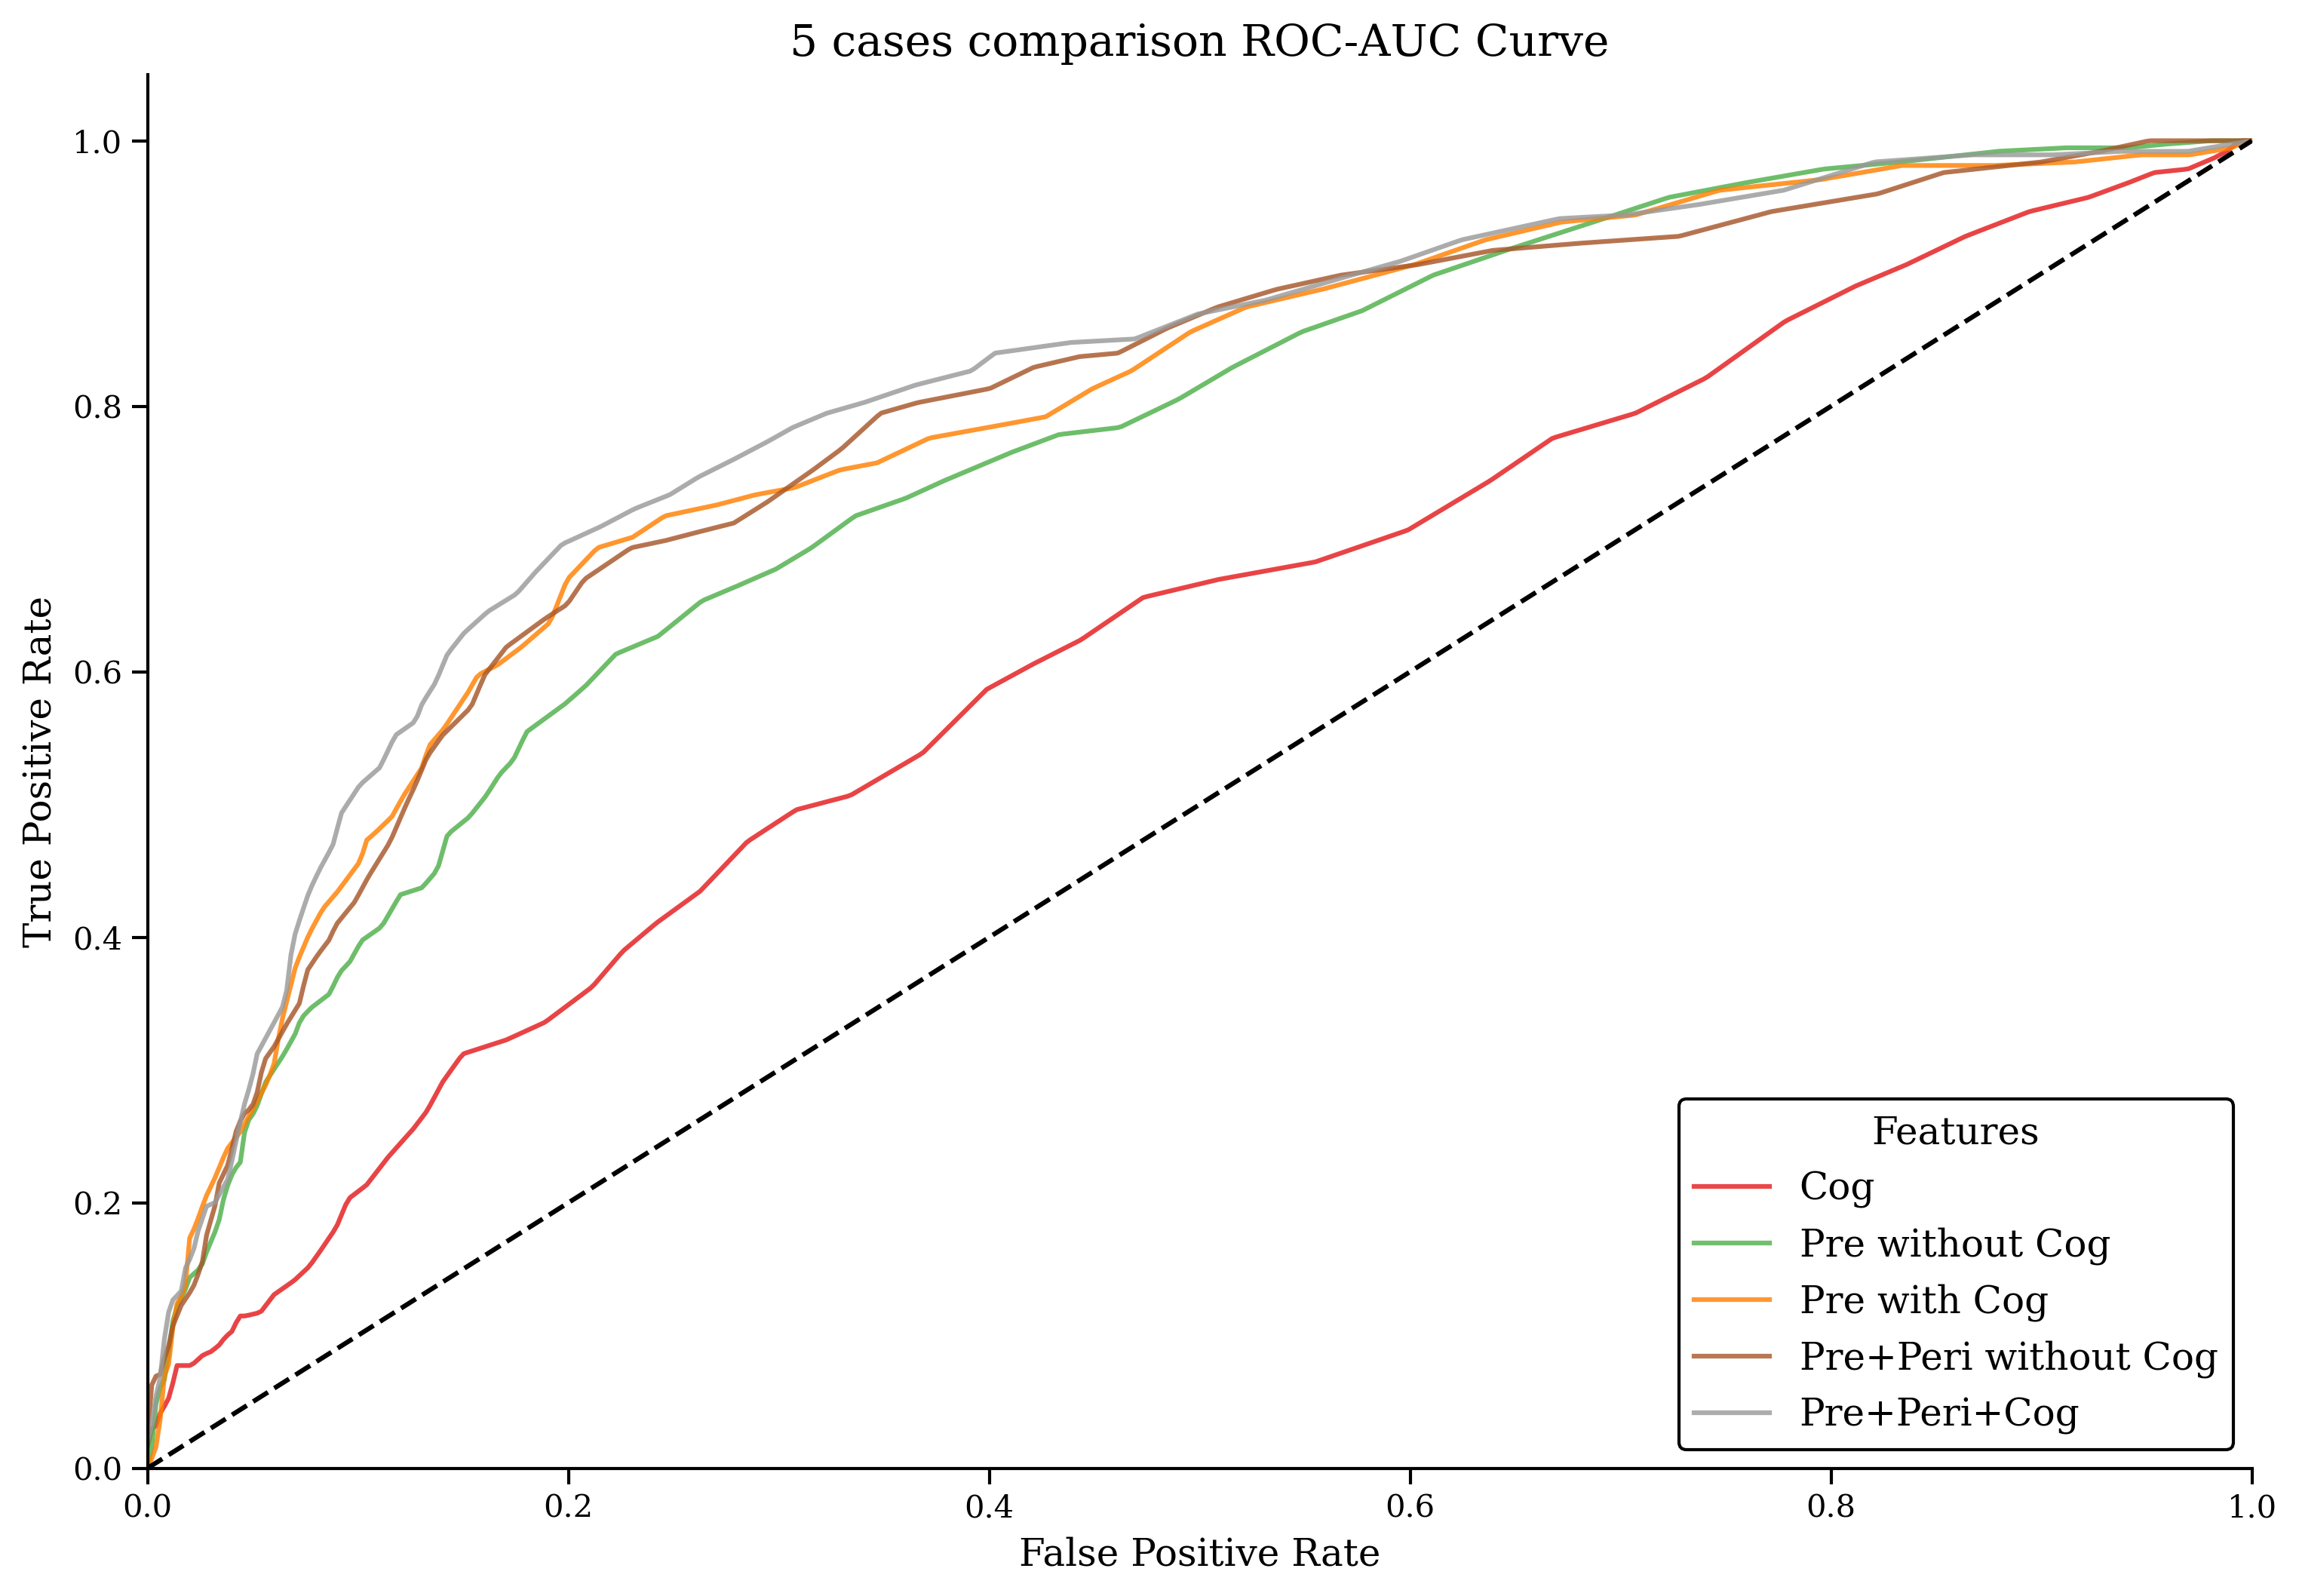

In [39]:
##########################################################################
# ROC AUC curve custom and most flexible plotting code
##########################################################################
# Preoperative and with cognitive as well

model_list= [RandomForestClassifier(n_jobs=-1)]
model_list1= ['Random Forest']

feat_list = [pre_cog, pre_demo+pre_physio+pre_surgi, pre_demo+pre_physio+pre_surgi+pre_cog,
             pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi, pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi+pre_cog ]

feat_names_list = ['pre_cog', 'pre_demo+pre_physio+pre_surgi', 'pre_demo+pre_physio+pre_surgi+pre_cog',
             'pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi', 'pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi+pre_cog' ]


names = ['Cog', 'Pre without Cog', 'Pre with Cog', 'Pre+Peri without Cog',
         'Pre+Peri+Cog']

auc_case_stats = pd.DataFrame()
ML_result_frame2  = pd.DataFrame()
for i, feat_names in enumerate(feat_list):
    
    # TO deal with hot endcoded features as their name changes when we hot encode them
    to_code = list(set(feat_names).intersection(set(encod_col)))
    feat_names1 = [i for i in feat_names if i not in to_code] # Removing the previous names
    if(len(to_code)!=0):
        to_add = []
        for col_name in to_code:
            to_add.append([col for col in final_frame.columns if col_name in col])
        ravel_list = np.concatenate(to_add).ravel()
        feat_names1  = feat_names1 + list(ravel_list) # Adding the new names it has after dummies
        
    
    X = final_frame.loc[:, feat_names1]
    Y = final_frame.loc[:,'T9_Delirum']
    
    feature_imp1, feature_all_frame1,ML_result_frame1,_,_ = ns_ML_model_test(model_list,model_list1,X,Y,5,apply_SMOTE=False,feat_len=None,return_proba=True, return_coef=False, n_repeats=1)
    print(f'Case:{names[i]}, ROC-AUC: {np.mean(ML_result_frame1.roc_auc[0])}')
    temp = pd.DataFrame({'Case':[names[i]], 'AUC ROC': [np.mean(ML_result_frame1.roc_auc[0])]})
    auc_case_stats =pd.concat([auc_case_stats, temp], axis = 0, join='outer')

    # Renamaing the columns for second dataframe: S_ means SMOTE
    ML_result_frame1.columns = [names[i] + s for s in list(ML_result_frame1.columns)]

    ML_result_frame2 =pd.concat([ML_result_frame1, ML_result_frame2], axis = 1)


auc_case_stats = auc_case_stats.reset_index(drop=True)
auc_case_stats.to_csv(os.path.join(save_files, ' ROC-AUC Curve values.csv'), index=False)


### Plotting ROC AUC curve - Custom
model_name = 'Random Forest'
img_str = '5 cases comparison'

# Color map for models
n=len(feat_names_list)
# cmap = plt.get_cmap("tab20")
cmap = plt.get_cmap("Set1")

colors = cmap.colors
indices = np.linspace(0, len(colors) - 1, n, dtype=int) # ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
color_map = [colors[i] for i in indices]


fig, ax = plt.subplots(figsize=(12,8))

for i, oversample in enumerate(names):
    
  prefix = oversample

  fpr = ML_result_frame2[ML_result_frame2[prefix+'model'] == model_name][prefix+'fpr'].values[0]
  tpr = ML_result_frame2[ML_result_frame2[prefix+'model'] == model_name][prefix+'tpr'].values[0]
  
  ### 
  interp_fpr = np.linspace(0, 1, 500) 
  fpr1=np.empty((fpr.shape[0],interp_fpr.shape[0]))
  tpr1=np.empty((tpr.shape[0],interp_fpr.shape[0]))
  for j in range(fpr.shape[0]):
      interp_tpr = np.interp(interp_fpr, fpr[j], tpr[j])

      fpr1[j,:] = interp_fpr
      tpr1[j,:] = interp_tpr
      

  mean_fpr = np.mean(fpr1, axis=0)
  mean_tpr = np.mean(tpr1, axis=0)
  
  std_fpr = np.std(fpr1, axis=0)
  std_tpr = np.std(tpr1, axis=0)

  # Plot shaded CI region
  ax.fill_between(mean_fpr, mean_tpr - 1.96*std_tpr/np.sqrt(len(tpr)),  
                  mean_tpr + 1.96*std_tpr/np.sqrt(len(tpr)), alpha=0.1, 
                  color=color_map[i])

  # Plot mean ROC curve   
  ax.plot(mean_fpr, mean_tpr, linewidth=1.5, color=color_map[i],
          label=oversample, alpha = 0.8)

ax.plot([0,1], [0,1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(img_str + ' ROC-AUC Curve') 

ax.legend(loc='lower right', borderaxespad=0.5,title='Features') 

fig.savefig(os.path.join(image_folder, img_str + ' ROC-AUC Curve' + '.png'), dpi=300)

## Permutation Testing

In [ ]:
# # Permutation test for all 7+7 cases based on their ROC-AUC values

model_list= [RandomForestClassifier(n_jobs=-1)]

model_list1= ['Random Forest']
#### Creating feature list to run for loop on it

pre_demo = list(set(Preoperative).intersection(set(Demographic)))
pre_physio = list(set(Preoperative).intersection(set(Physiological)))
pre_surgi = list(set(Preoperative).intersection(set(Surgical)))
pre_cog = list(set(Preoperative).intersection(set(Cognitive)))
intervention = ['Gruppe']

peri_physio = list(set(Perioperative).intersection(set(Physiological)))
peri_surgi = list(set(Perioperative).intersection(set(Surgical)))

all_feat = list(Preoperative) + list(Perioperative)
all_except_peri = set(all_feat).difference(set(Perioperative))

feat_list = [pre_demo, pre_physio, pre_surgi, peri_physio, peri_surgi, pre_demo+pre_physio+pre_surgi,
             pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi]

feat_names_list = ['pre_demo', 'pre_physio', 'pre_surgi', 'peri_physio', 'peri_surgi', 'pre_demo+pre_physio+pre_surgi',
             'pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi']

# Hot encoded features:
encod_col = ['location','T1_SMI', 'T2_narc_kind', 'T2_OP_kind_general']


# Adding Cognition
for i in range(len(feat_list)):
    new_list= feat_list[i] + pre_cog
    new_name = feat_names_list[i] + '+pre_cog'
    feat_list.append(new_list)
    feat_names_list.append(new_name)
    
feat_list = feat_list + [pre_cog]
feat_names_list = feat_names_list + ['pre_cog']


# Including the feature called "Gruppe"
feat_list = feat_list + [intervention] + [pre_demo+pre_physio+pre_surgi+pre_cog + intervention] + [pre_demo+pre_physio+pre_surgi+pre_cog + peri_physio+peri_surgi + intervention]
feat_names_list = feat_names_list + ['intervention'] + ['Pre+cog+intervention'] + ['Pre+cog+Peri+intervention']


# Hot encoded features:
encod_col = ['location','T1_SMI', 'T2_narc_kind', 'T2_OP_kind_general']

total_perm = 1001

df_each_case = pd.DataFrame()
df_each_case.insert(0,column='Case', value=feat_names_list)
df_each_case = pd.concat([df_each_case, pd.DataFrame(np.zeros((len(df_each_case),total_perm)))],axis=1, join='outer', ignore_index=False)



In [ ]:

### Saving permutted Y values to keep the results stable across different runs

# df_each_case.iloc[0:14,:] = df_each_case1.loc[0:14,:]
# # Save permuted y values
# Y_perm_frame =  pd.DataFrame()
# for perm_val in range(total_perm):
#     Y = final_frame.loc[:,'T9_Delirum'].values
    
#     if (perm_val !=0):
#         Y = np.random.permutation(Y)
        
#     Y_perm_frame.insert(perm_val, perm_val, Y)
    
# Y_perm_frame.to_csv(os.path.join(save_files,'Y_permutations_original_and_1000'+'.csv'), index=False)

In [ ]:

Y_perm_frame = pd.read_csv(r'../intermediate_files/Y_permutations_original_and_1000.csv', dtype=float, low_memory=False)

for i, (feat_names, case_name) in enumerate(zip(feat_list,feat_names_list)):
    print(f'\n Iteration number {i+1}/{len(feat_list)} \n')
    
    # if (i<15):
    #     print('Skipping')
    #     continue;
        
    print(f'Case name: {case_name}')
    # TO deal with hot endcoded features as their name changes when we hot encode them
    to_code = list(set(feat_names).intersection(set(encod_col)))
    feat_names1 = [i for i in feat_names if i not in to_code] # Removing the previous names
    if(len(to_code)!=0):
        to_add = []
        for col_name in to_code:
            to_add.append([col for col in final_frame.columns if col_name in col])
        ravel_list = np.concatenate(to_add).ravel()
        feat_names1  = feat_names1 + list(ravel_list) # Adding the new names it has after dummies
        
    
    X = final_frame.loc[:, feat_names1]
    
    for perm_val in range(total_perm):
           
        Y = Y_perm_frame.iloc[:,perm_val]
        
        feature_imp1, feature_all_frame1,ML_result_frame1,_,_ = ns_ML_model_test(model_list,model_list1,X,Y,5,apply_SMOTE=False,feat_len=None,return_proba=True, return_coef=False, n_repeats=1)
        
        df_each_case.iloc[i,perm_val+1] = ML_result_frame1.roc_auc[0][0]
    
        if (perm_val%100 == 0):
            print(f'\n Iteration number {i+1}/{len(feat_list)} \n')
            print(f'\n Permutation number {perm_val+1}/{total_perm} \n')
         
            df_each_case.to_csv(r'../intermediate_files/Permutation_11-7_cases_ROCval_1001_perm'+'.csv', index=False)

#### Figure 1-C

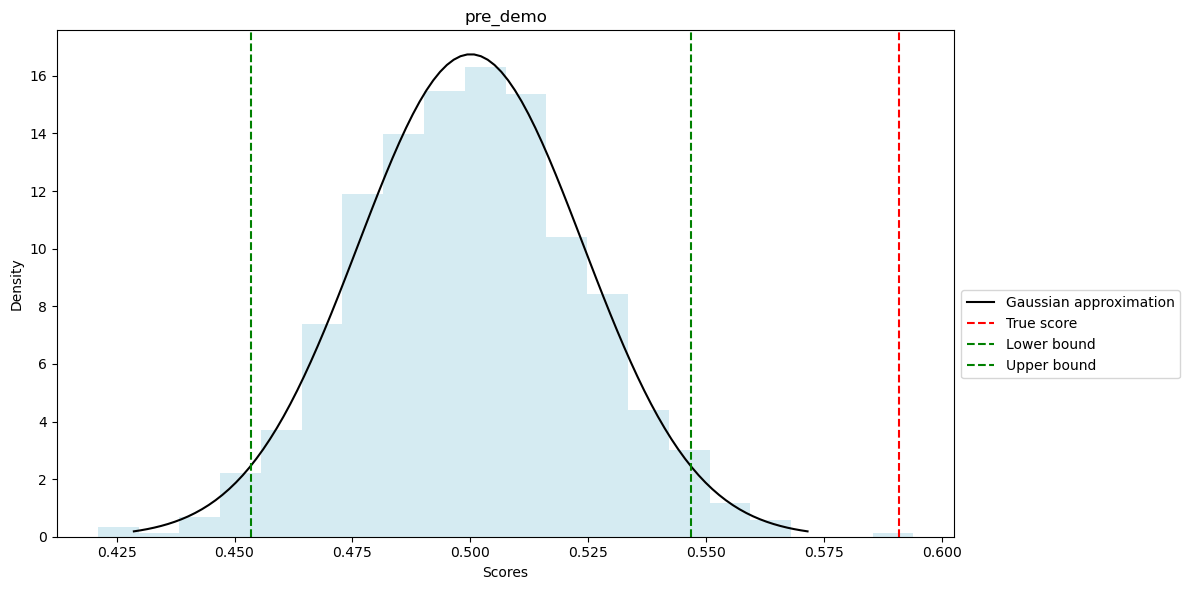

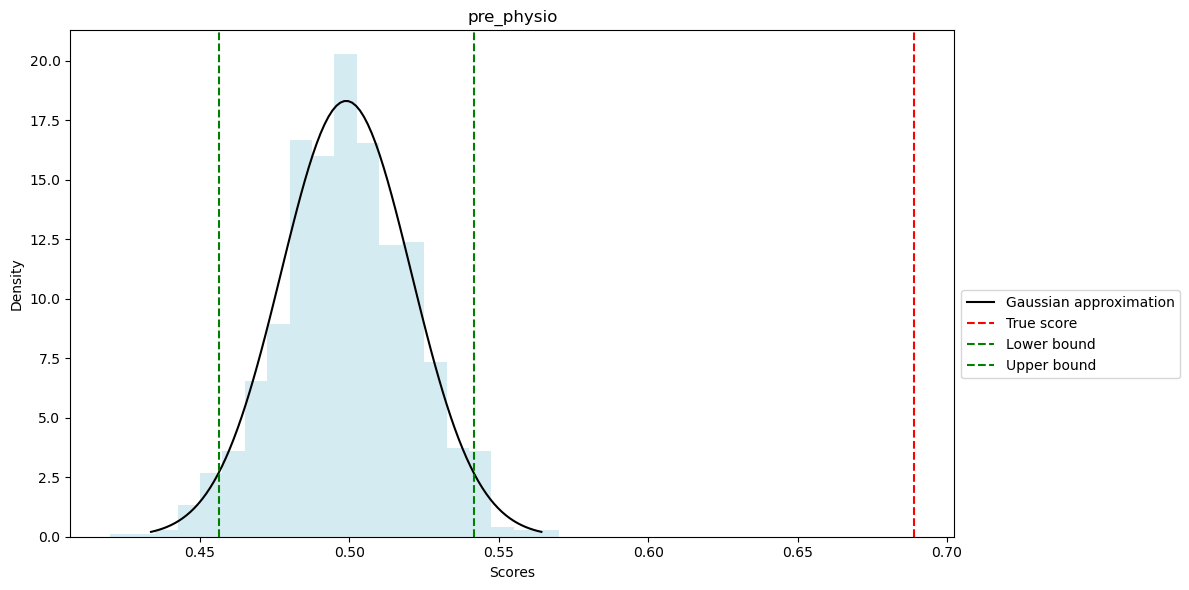

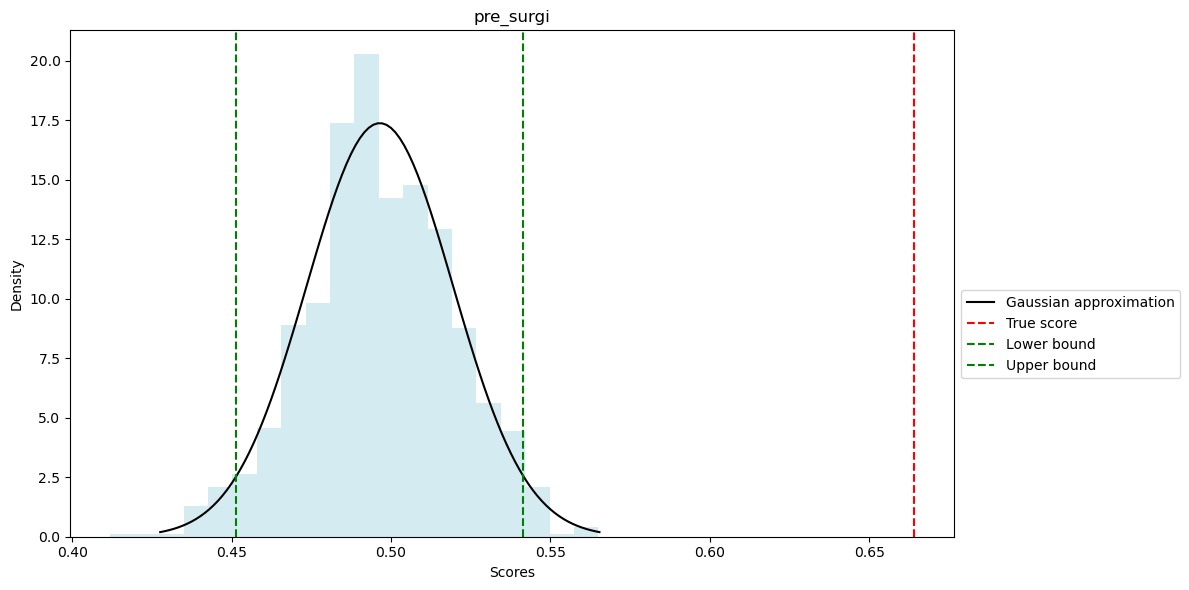

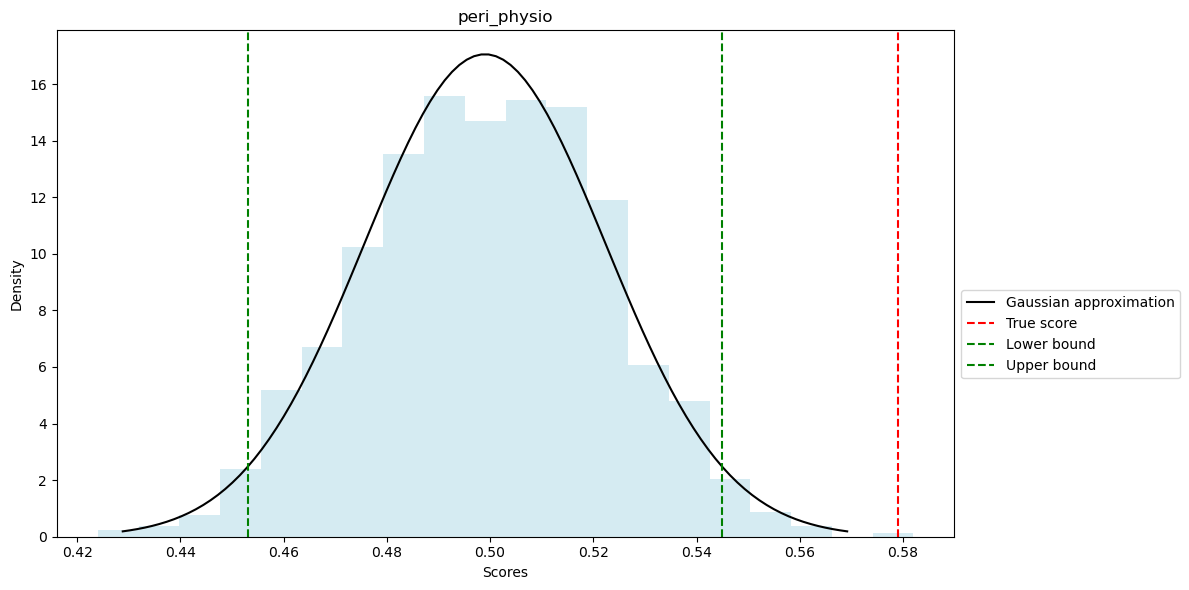

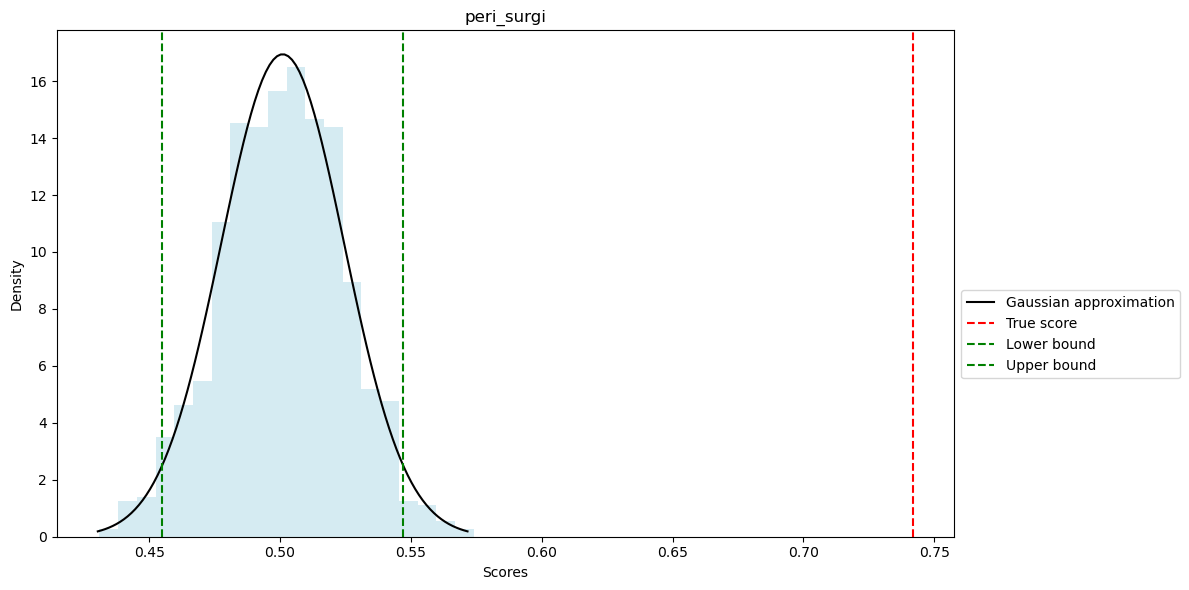

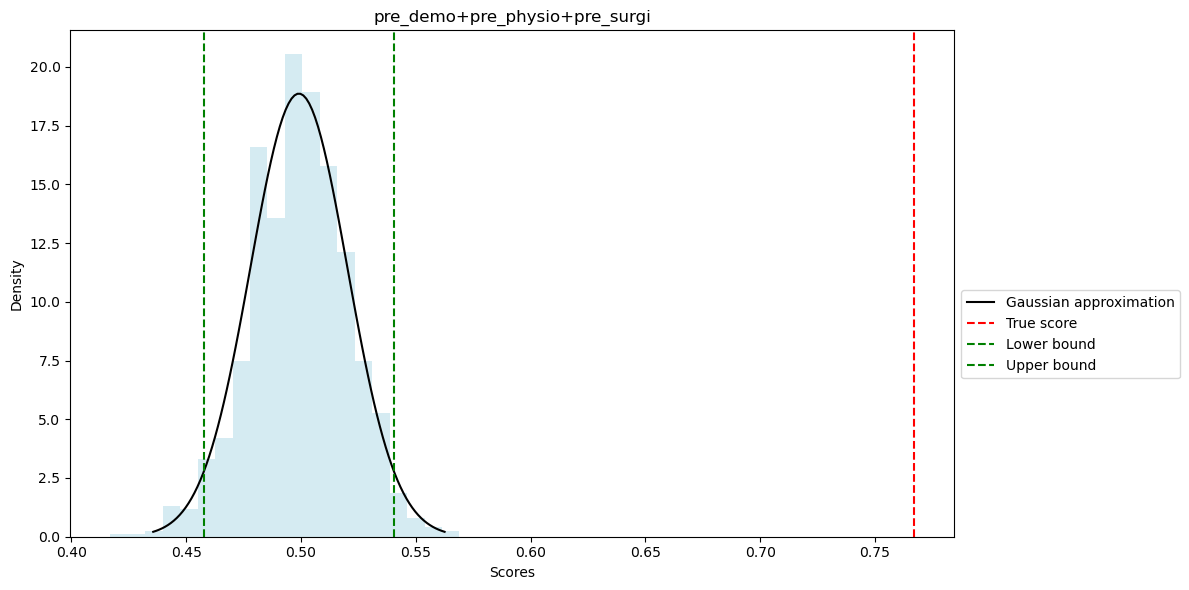

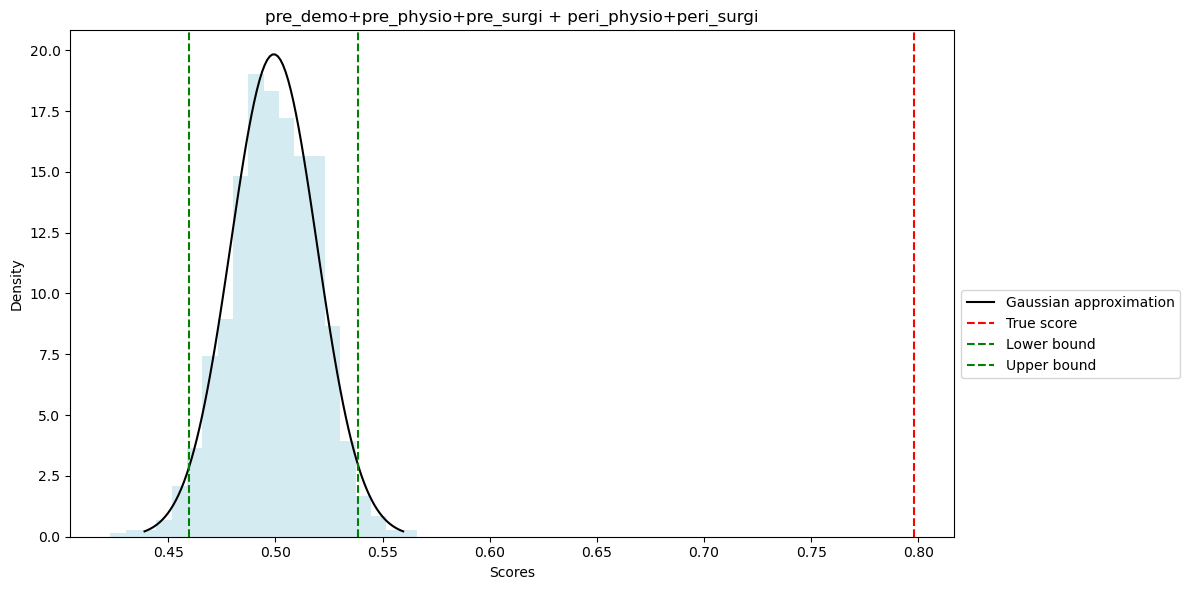

In [44]:
# Loading the saved permutation file for plotting
df_each_case = pd.read_csv(r'../intermediate_files/Permutation_11-7_cases_ROCval_1001_perm'+'.csv')

p_value_diff = pd.DataFrame({'Cases': [], 'p_value':[]})
feat_list = [pre_demo, pre_physio, pre_surgi, peri_physio, peri_surgi, pre_demo+pre_physio+pre_surgi,
             pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi]

feat_names_list = ['pre_demo', 'pre_physio', 'pre_surgi', 'peri_physio', 'peri_surgi', 'pre_demo+pre_physio+pre_surgi',
             'pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi']

for i in range(len(feat_list)):
    for j in range(len(feat_list)):
        case = str(df_each_case.iloc[i,0]) + ' || ' + str(df_each_case.iloc[j,0])

        true_score = df_each_case.iloc[i,1] - df_each_case.iloc[j,1]
        scores =  df_each_case.iloc[i,2:].values - df_each_case.iloc[j,2:].values
        scores = np.array(scores, dtype=float)
        # Run test  
        p_value = permutation_test_pval(true_score, scores)
        
        #print(f'For model:{model_list1[0]}, t_value: {t_value},  p_value: {p_value}')
        
        
        p_value_diff.loc[len(p_value_diff.index)] = [case, p_value] 
        
        
p_value_diff.to_csv(r'../intermediate_files/Permutation_11-7-case-difference_p_val_for_1001_iterations'+'.csv', index=False)
#################################
# Now doing paired t test for by chance

p_val_chance = pd.DataFrame({'Cases': [], 'p_value':[]})

for i in range(len(feat_list)):
        case = str(df_each_case.iloc[i,0]) 

        true_score = df_each_case.iloc[i,1]
        scores =  df_each_case.iloc[i,2:].values
        # Plot permutation histogram plot
        permutation_histogramplot(scores, true_score, img_str=case, image_folder=image_folder)
        
        # Run test  
        p_value = permutation_test_pval(true_score, scores)
        
        p_val_chance.loc[len(p_val_chance.index)] = [case, p_value] 
        
p_val_chance.to_csv(r'../intermediate_files/Permutation_11-7-case-itself_bychance_p_val_for_1001_iterations'+'.csv', index=False)



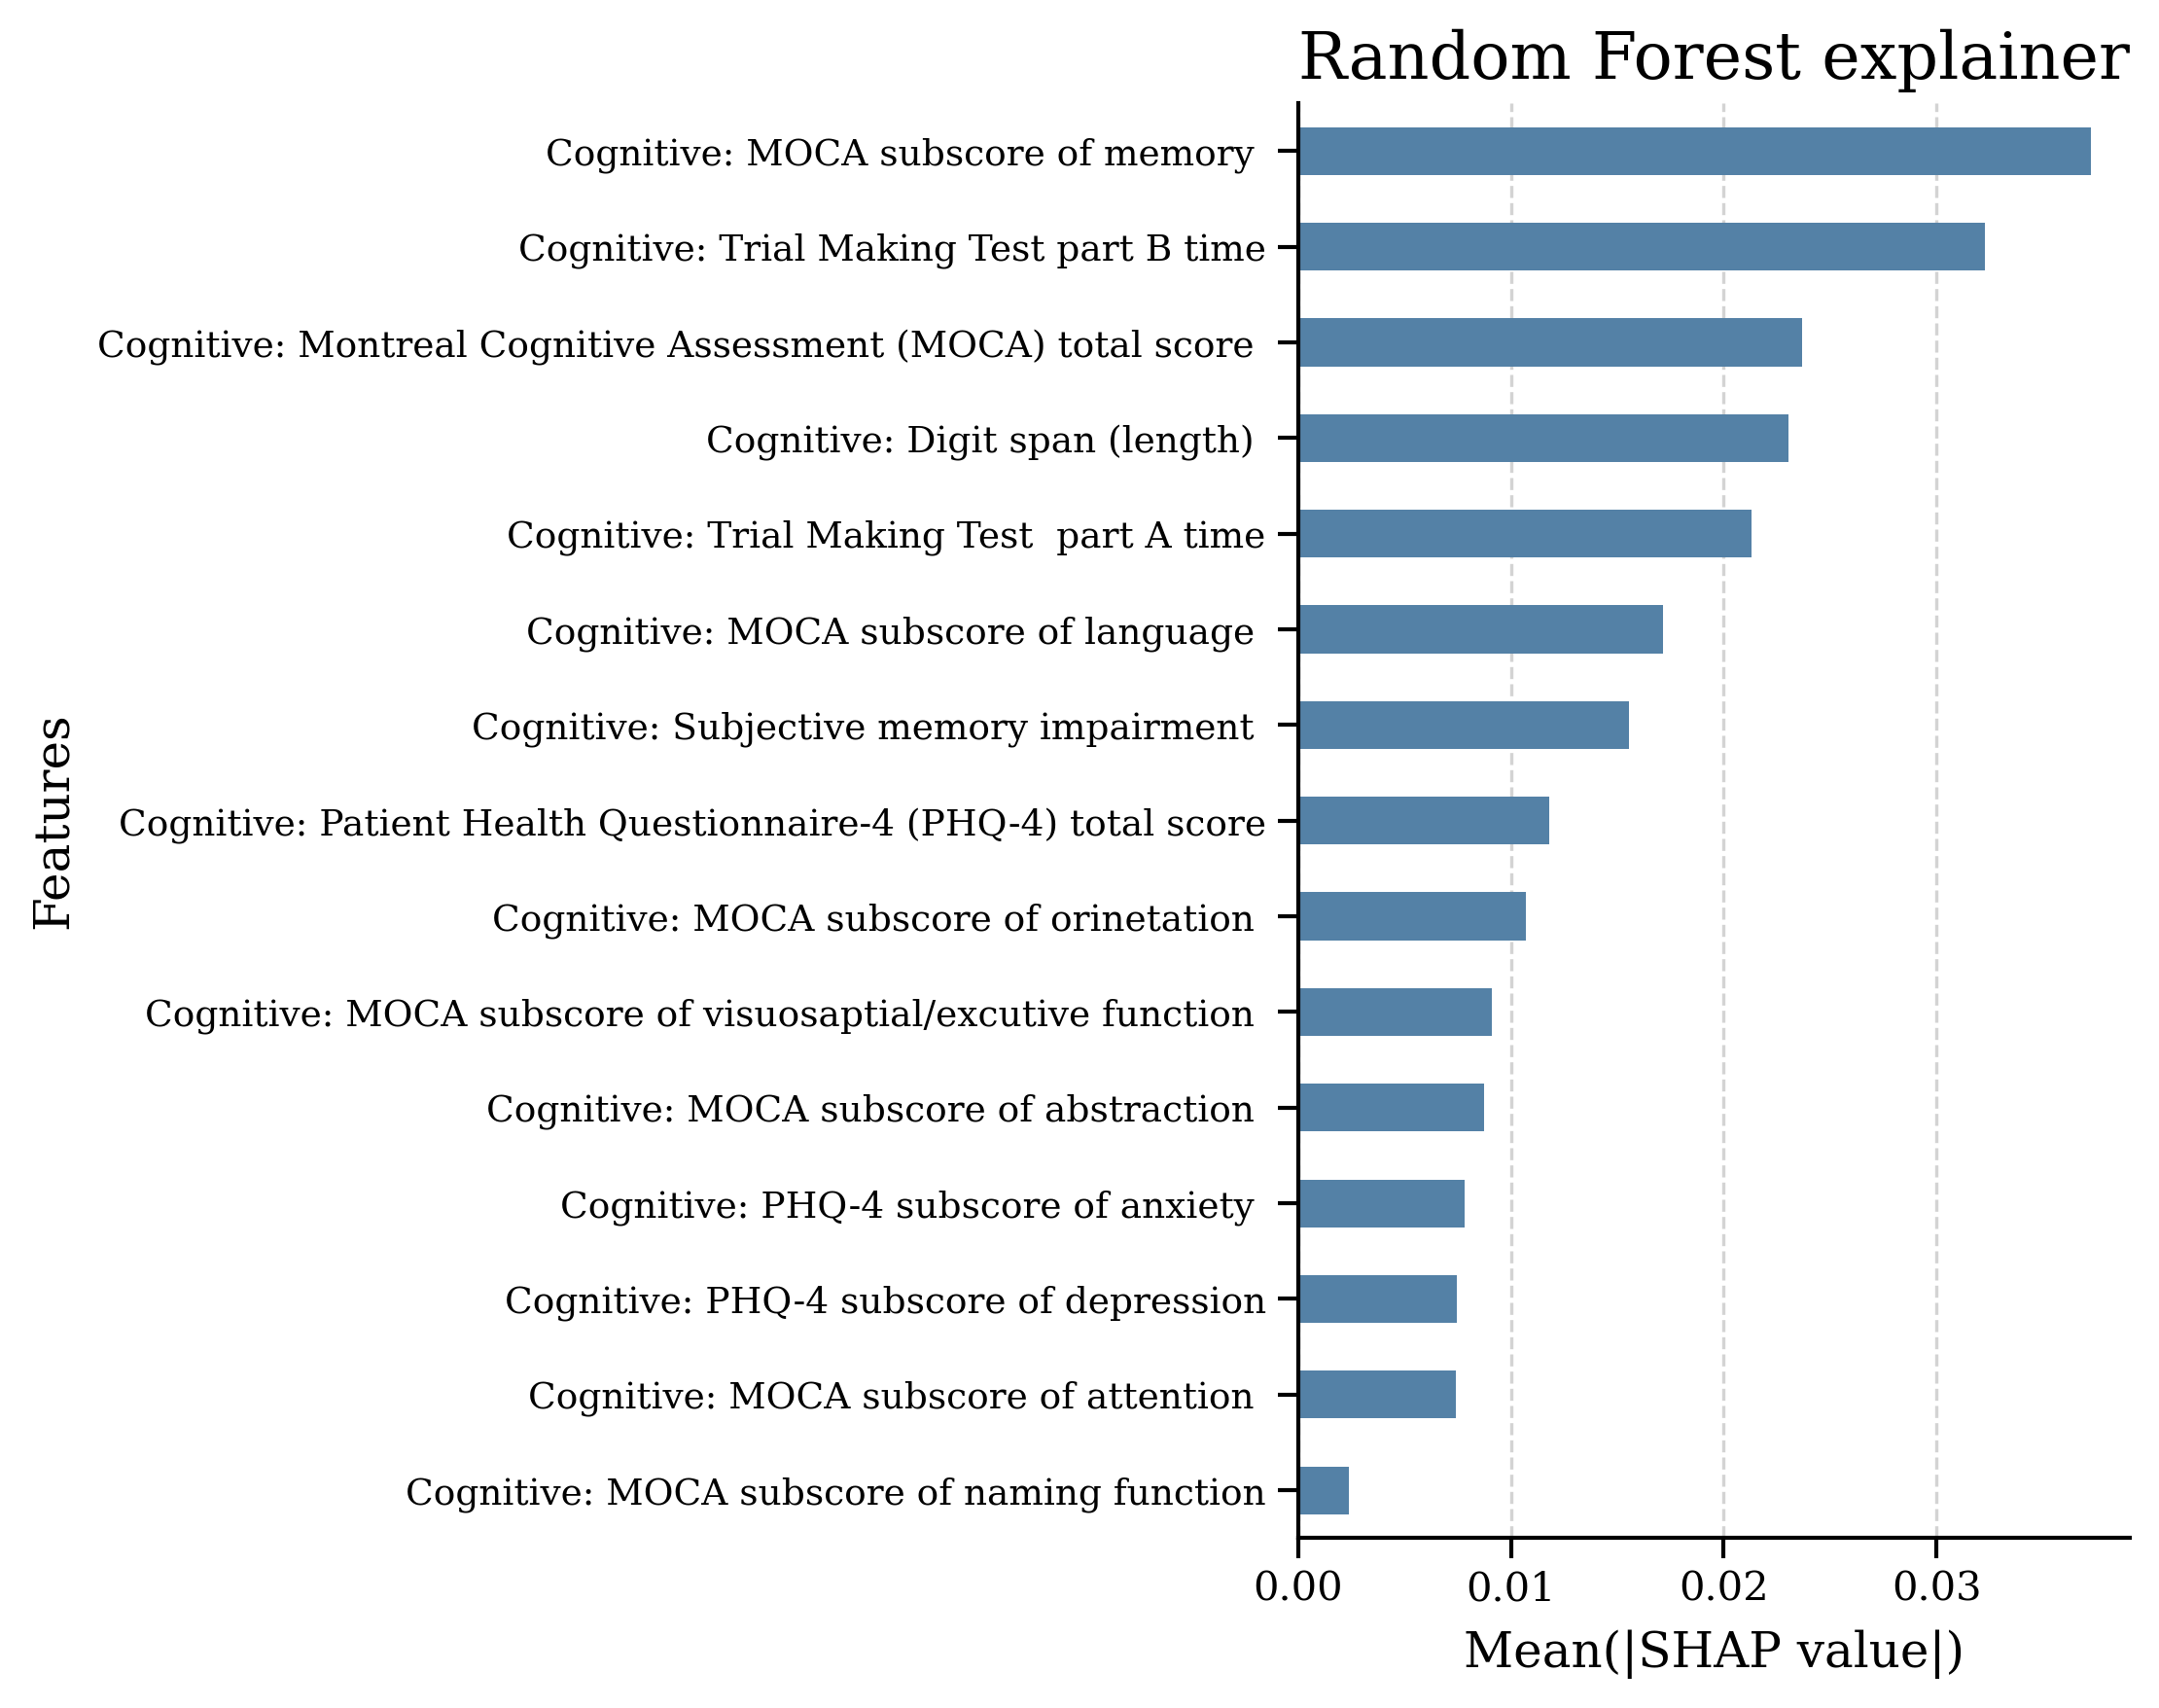

In [84]:

# # #### SHAP plot for all features
feat_name_here = pre_cog
feat_names1 = change_feat_to_hotenc(feat_name_here, encod_col, final_frame)    
X = final_frame.loc[:, feat_names1]
Y = final_frame.loc[:,'T9_Delirum']
shap_importance = shap_plot(X,Y, Cognitive,image_folder, feature_frame, clf_ind=2, scatter_plot=False, top_feat = 15,  title='Random Forest explainer',use_hue=False, return_val=True)
shap_importance.to_csv(r'../intermediate_files/cognitive_feat_shap_value.csv', index=False)


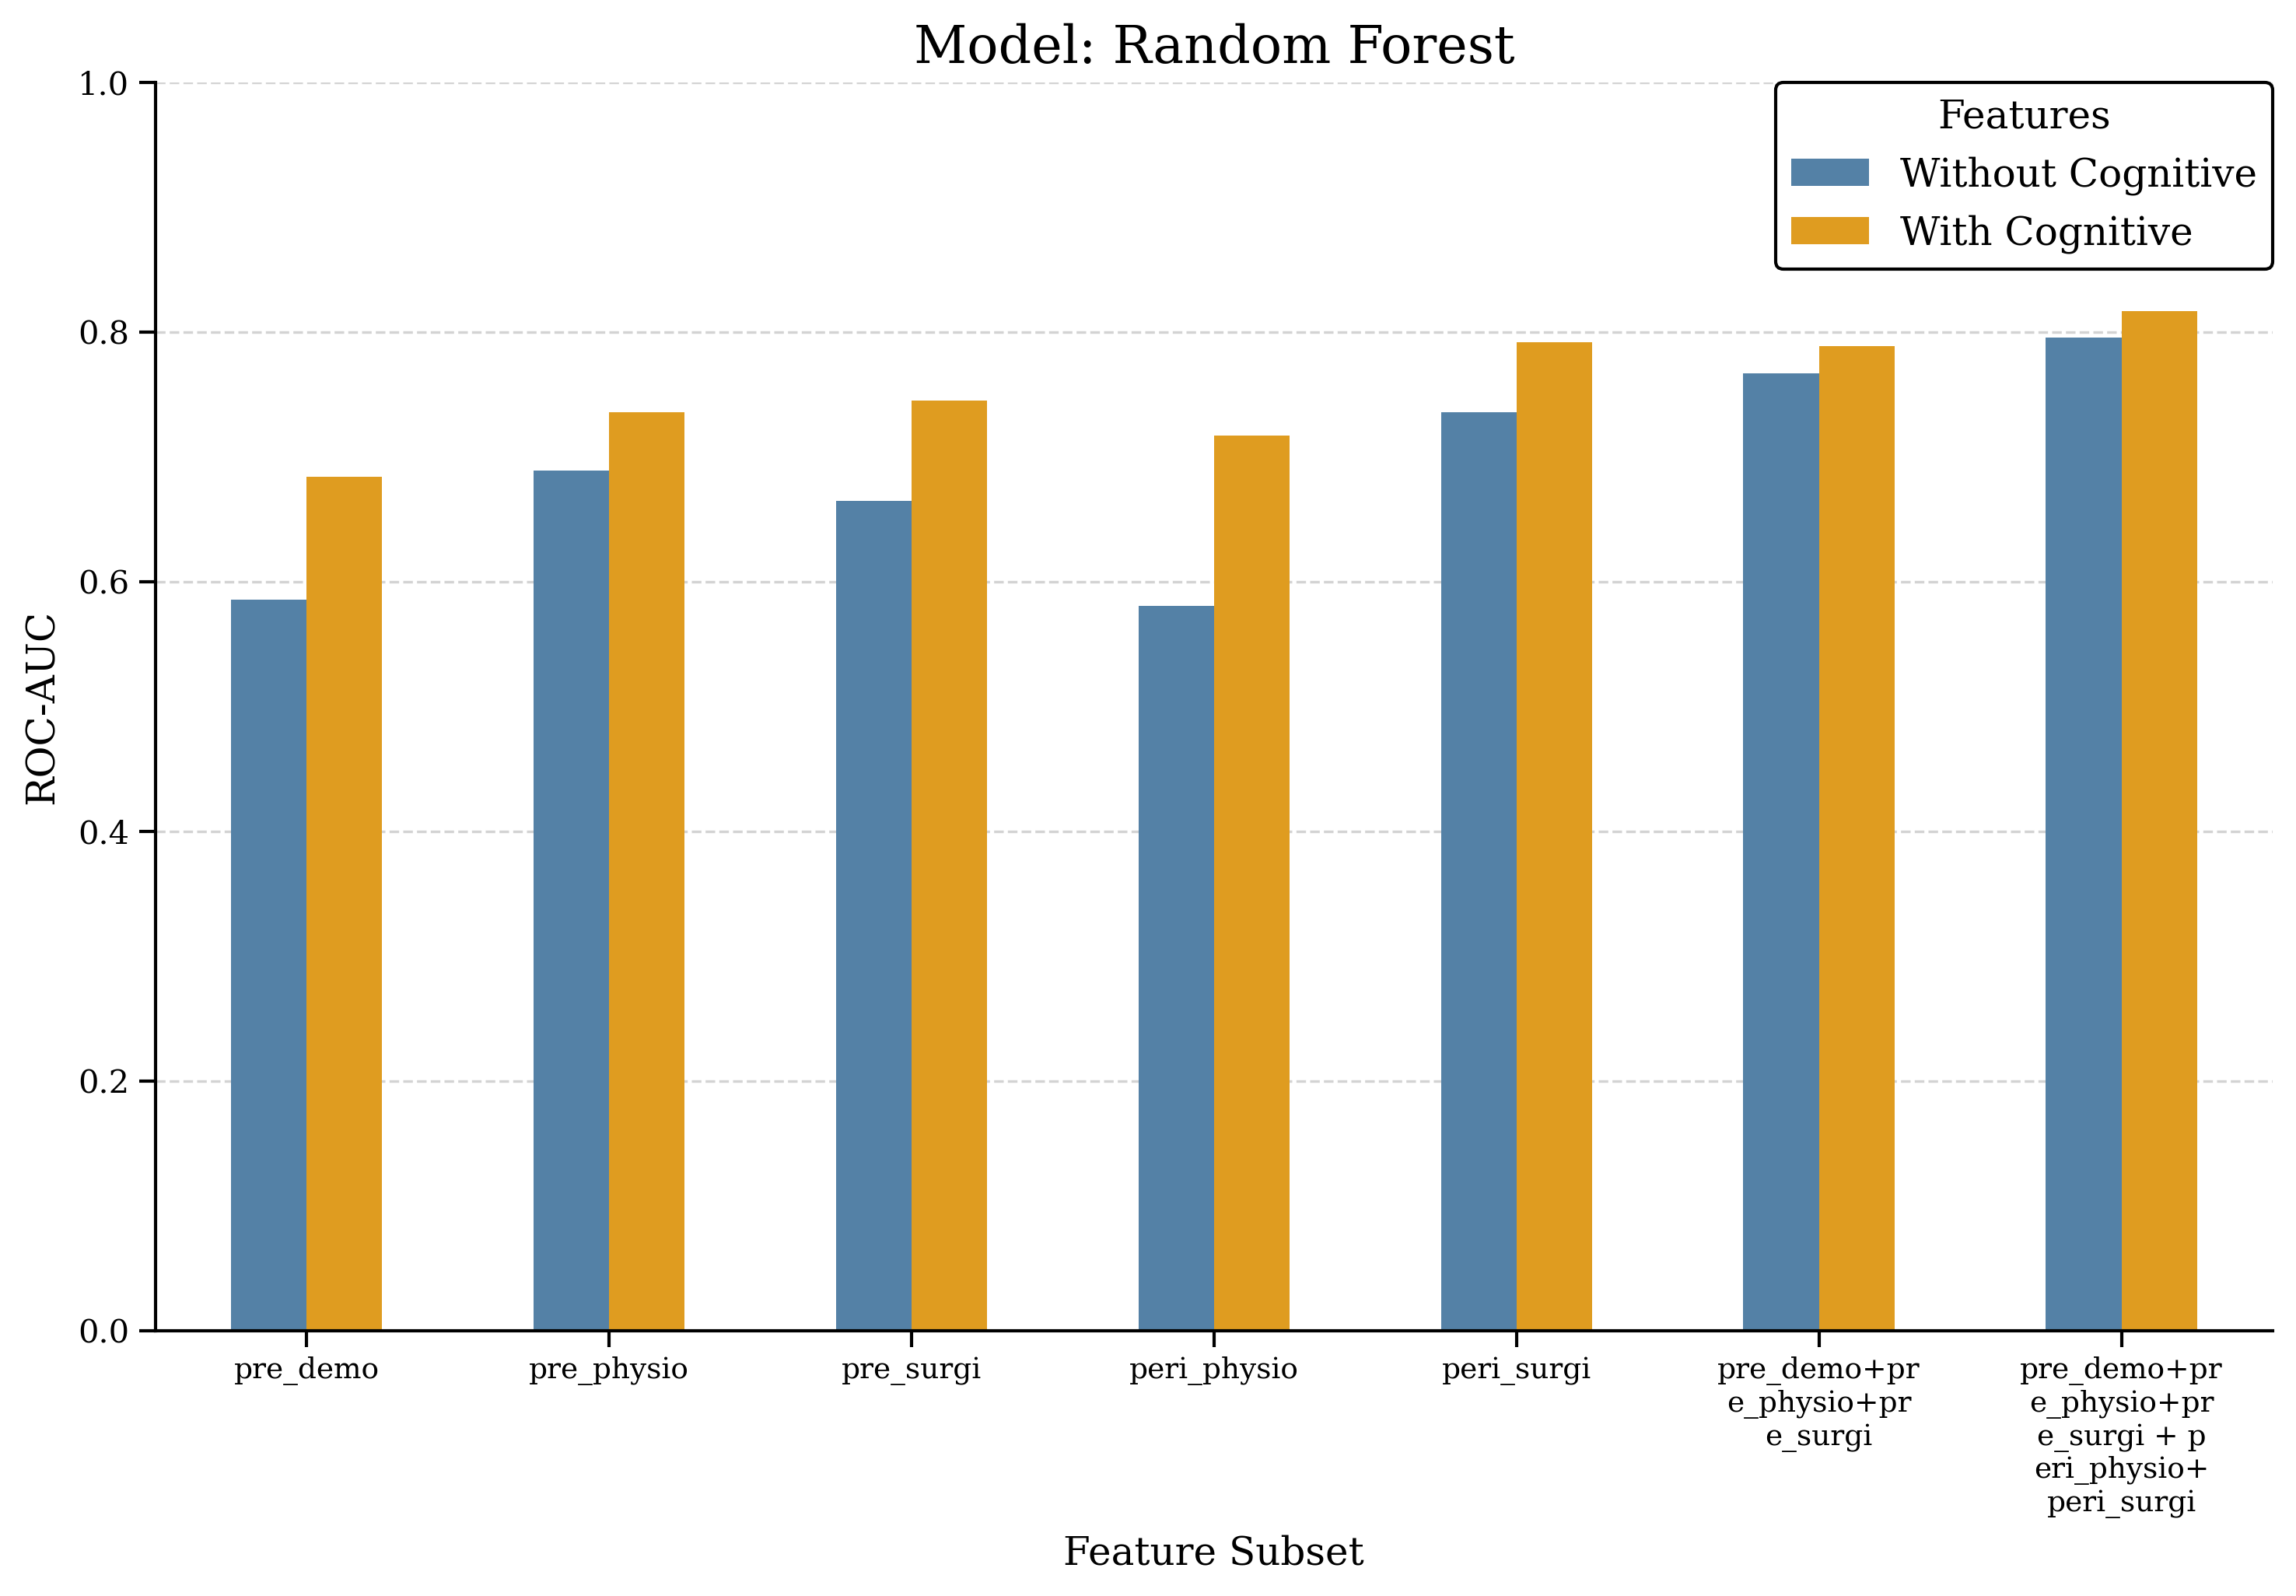

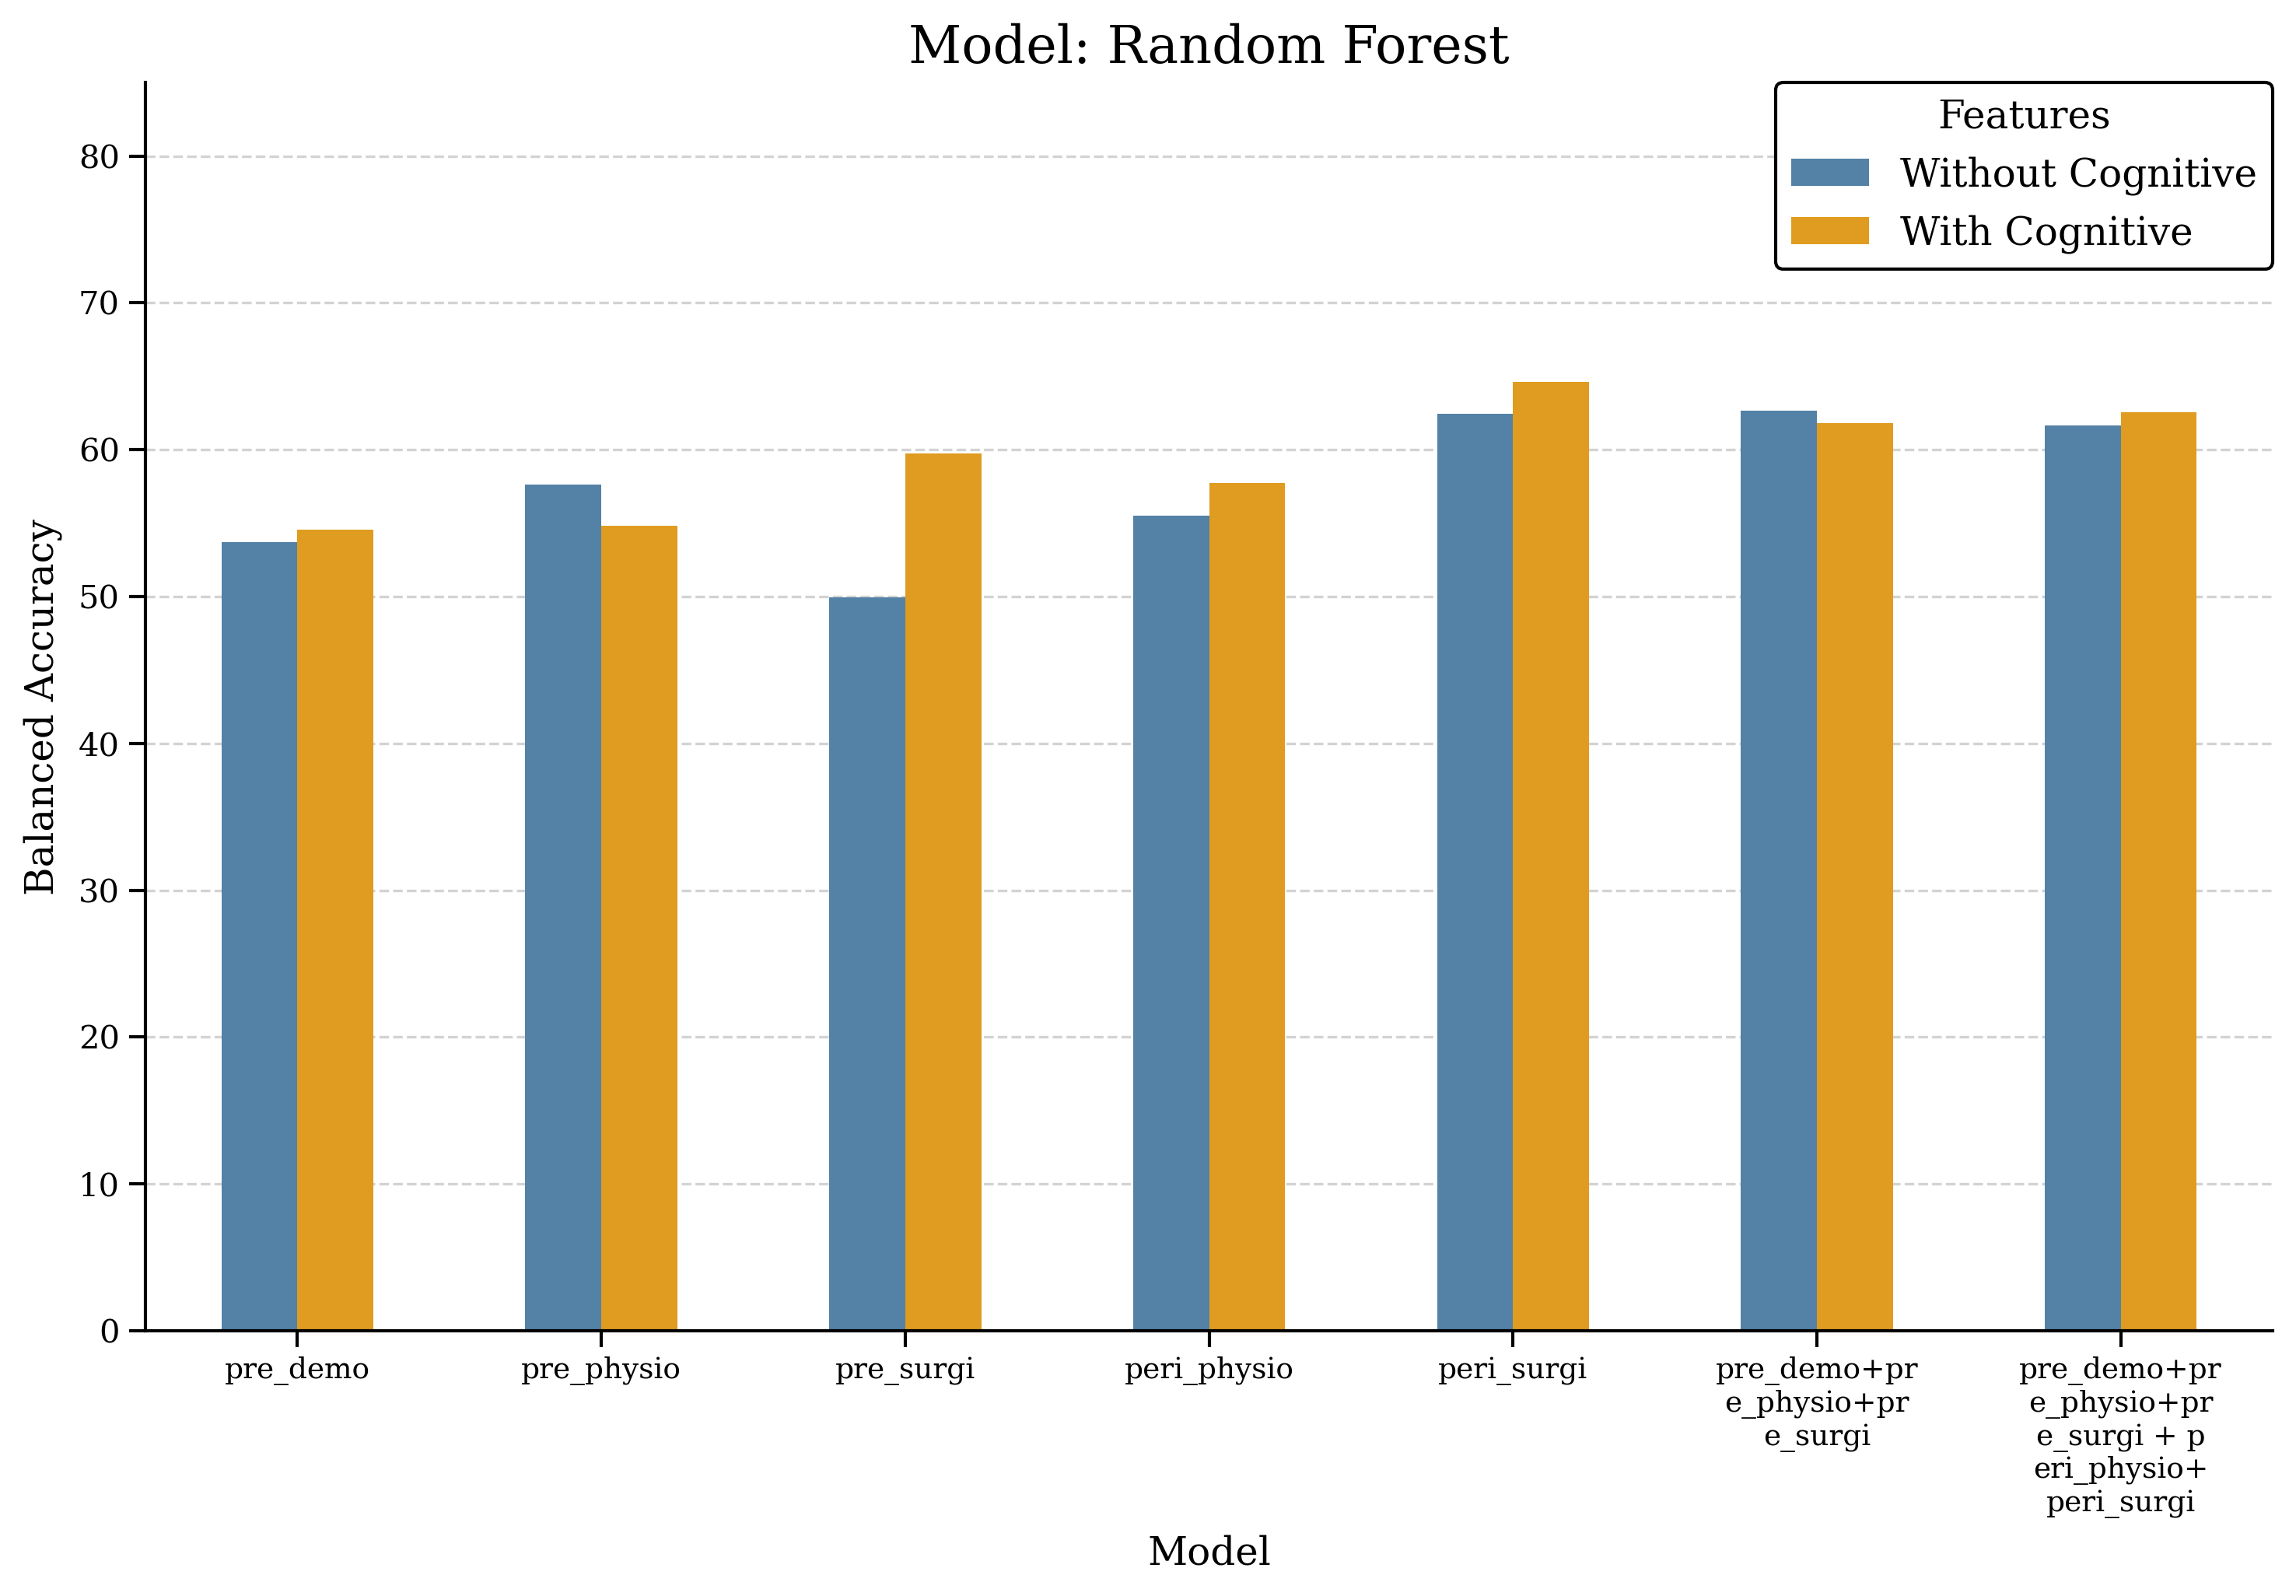

In [50]:
#############################################
# Getting the p values of the hue

p_value_diff = pd.read_csv(os.path.join(save_files,'Permutation_7-7-case-difference_p_val_for_1001_iterations'+'.csv'))
feat_names_list = ['pre_demo', 'pre_physio', 'pre_surgi', 'peri_physio', 'peri_surgi', 'pre_demo+pre_physio+pre_surgi',
             'pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi']
model_name = 'Random Forest' 

# Now importing the dataframe from which has ROC AUC value with hue for each of the 7-7 cases
df_each_case1 = pd.read_pickle(os.path.join(save_files,'ROC-AUC_7-7_case_bar_plot'+'.pkl'))

# Makiins sure to get the same order of p values as the dataframe having ROC AUC values
p_value_case = pd.DataFrame()
feat_names_list1 = list(df_each_case1.model)
for i in range(len(feat_names_list1)):
    new_name = feat_names_list1[i] + ' || ' + feat_names_list1[i] +'+pre_cog'
    p_value_frame = p_value_diff[p_value_diff.loc[:,'Cases'] == new_name]
    p_value_case = pd.concat([p_value_case,p_value_frame],join='outer', ignore_index=True, axis=0)

p_value_case  = p_value_case.reset_index(drop=True)
p_val_list = p_value_case.loc[:,'p_value'].values

bar_plot(df_each_case1, feat_names_list1 ,y_lim = 1.0, image_str= 'ROC-AUC_' + model_name , y_label='ROC-AUC', 
         title='Model: '+ model_name, var_list=['roc_auc','S_roc_auc'], set_y_line = None, x_label='Feature Subset',
         text_wrap=11, legend_list = ['Features', 'Without Cognitive', 'With Cognitive'], p_vals = p_val_list, image_folder=image_folder)
    

bar_plot(df_each_case1, feat_names_list1, y_lim = 85, image_str= 'Bal_acc_' + model_name, y_label='Balanced Accuracy', 
          title='Model: '+ model_name, var_list=['acc_bal','S_acc_bal'],set_y_line = None, text_wrap=11,
          legend_list = ['Features', 'Without Cognitive', 'With Cognitive'], p_vals = p_val_list, image_folder=image_folder)



## Supplementary figures

In [ ]:
# =============================================================================
# Big supplementary figure: All 10 cases and all four models
# =============================================================================

model_list= [SVC(C=1, kernel='linear',probability=True),
             RandomForestClassifier(n_jobs=-1),
             LogisticRegression(C=1,max_iter=1000000,n_jobs=-1),
             XGBClassifier()]
         
model_list1= ['Linear SVC',
             'Random Forest',
             'Logistic Regression',
             'Gradient boosting']


feat_list = [pre_demo, pre_physio, pre_surgi, peri_physio, peri_surgi, pre_demo+pre_physio+pre_surgi,
             pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi, pre_cog, pre_demo+pre_physio+pre_surgi+pre_cog,
             pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi+pre_cog]

feat_names_list = ['pre_demo', 'pre_physio', 'pre_surgi', 'peri_physio', 'peri_surgi', 'pre_demo+pre_physio+pre_surgi',
             'pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi', 'pre_cog', 'pre_demo+pre_physio+pre_surgi+pre_cog',
             'pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi+pre_cog']

names =  ['pre_demo', 'pre_physio', 'pre_surgi', 'peri_physio', 'peri_surgi', 'Pre w/o cog',
             'Pre+Peri w/o cog', 'pre_cog', 'Pre wih cog', 'Pre+Peri with cog']

img_str = '10 cases'

all_acc_frame= pd.DataFrame()

for i, feat_names in enumerate(feat_list):
    
    # Without Cognitive features
    feat_names1 = change_feat_to_hotenc(feat_names, encod_col, final_frame)
    
    X = final_frame.loc[:, feat_names1]
    Y = final_frame.loc[:,'T9_Delirum']
    
    feature_imp1, feature_all_frame1,ML_result_frame1,_,_ = ns_ML_model_test(model_list,model_list1,X,Y,5,apply_SMOTE=False,feat_len=None,return_proba=True, return_coef=False, n_repeats=1)
    
    temp_frame = pd.DataFrame({'Case': np.full((len(model_list)), names[i]), 'Model': ML_result_frame1.model,
                               'Balanced Accuracy': list(chain.from_iterable(ML_result_frame1.acc_bal.values))
                               , 'ROC-AUC': list(chain.from_iterable(ML_result_frame1.roc_auc.values))})

    all_acc_frame = pd.concat([all_acc_frame, temp_frame], join='outer', axis=0)


all_acc_frame = all_acc_frame.reset_index(drop=True)

all_acc_frame.to_csv(r'../intermediate_files/all_cases_4_model_acc_file.csv', index=False)


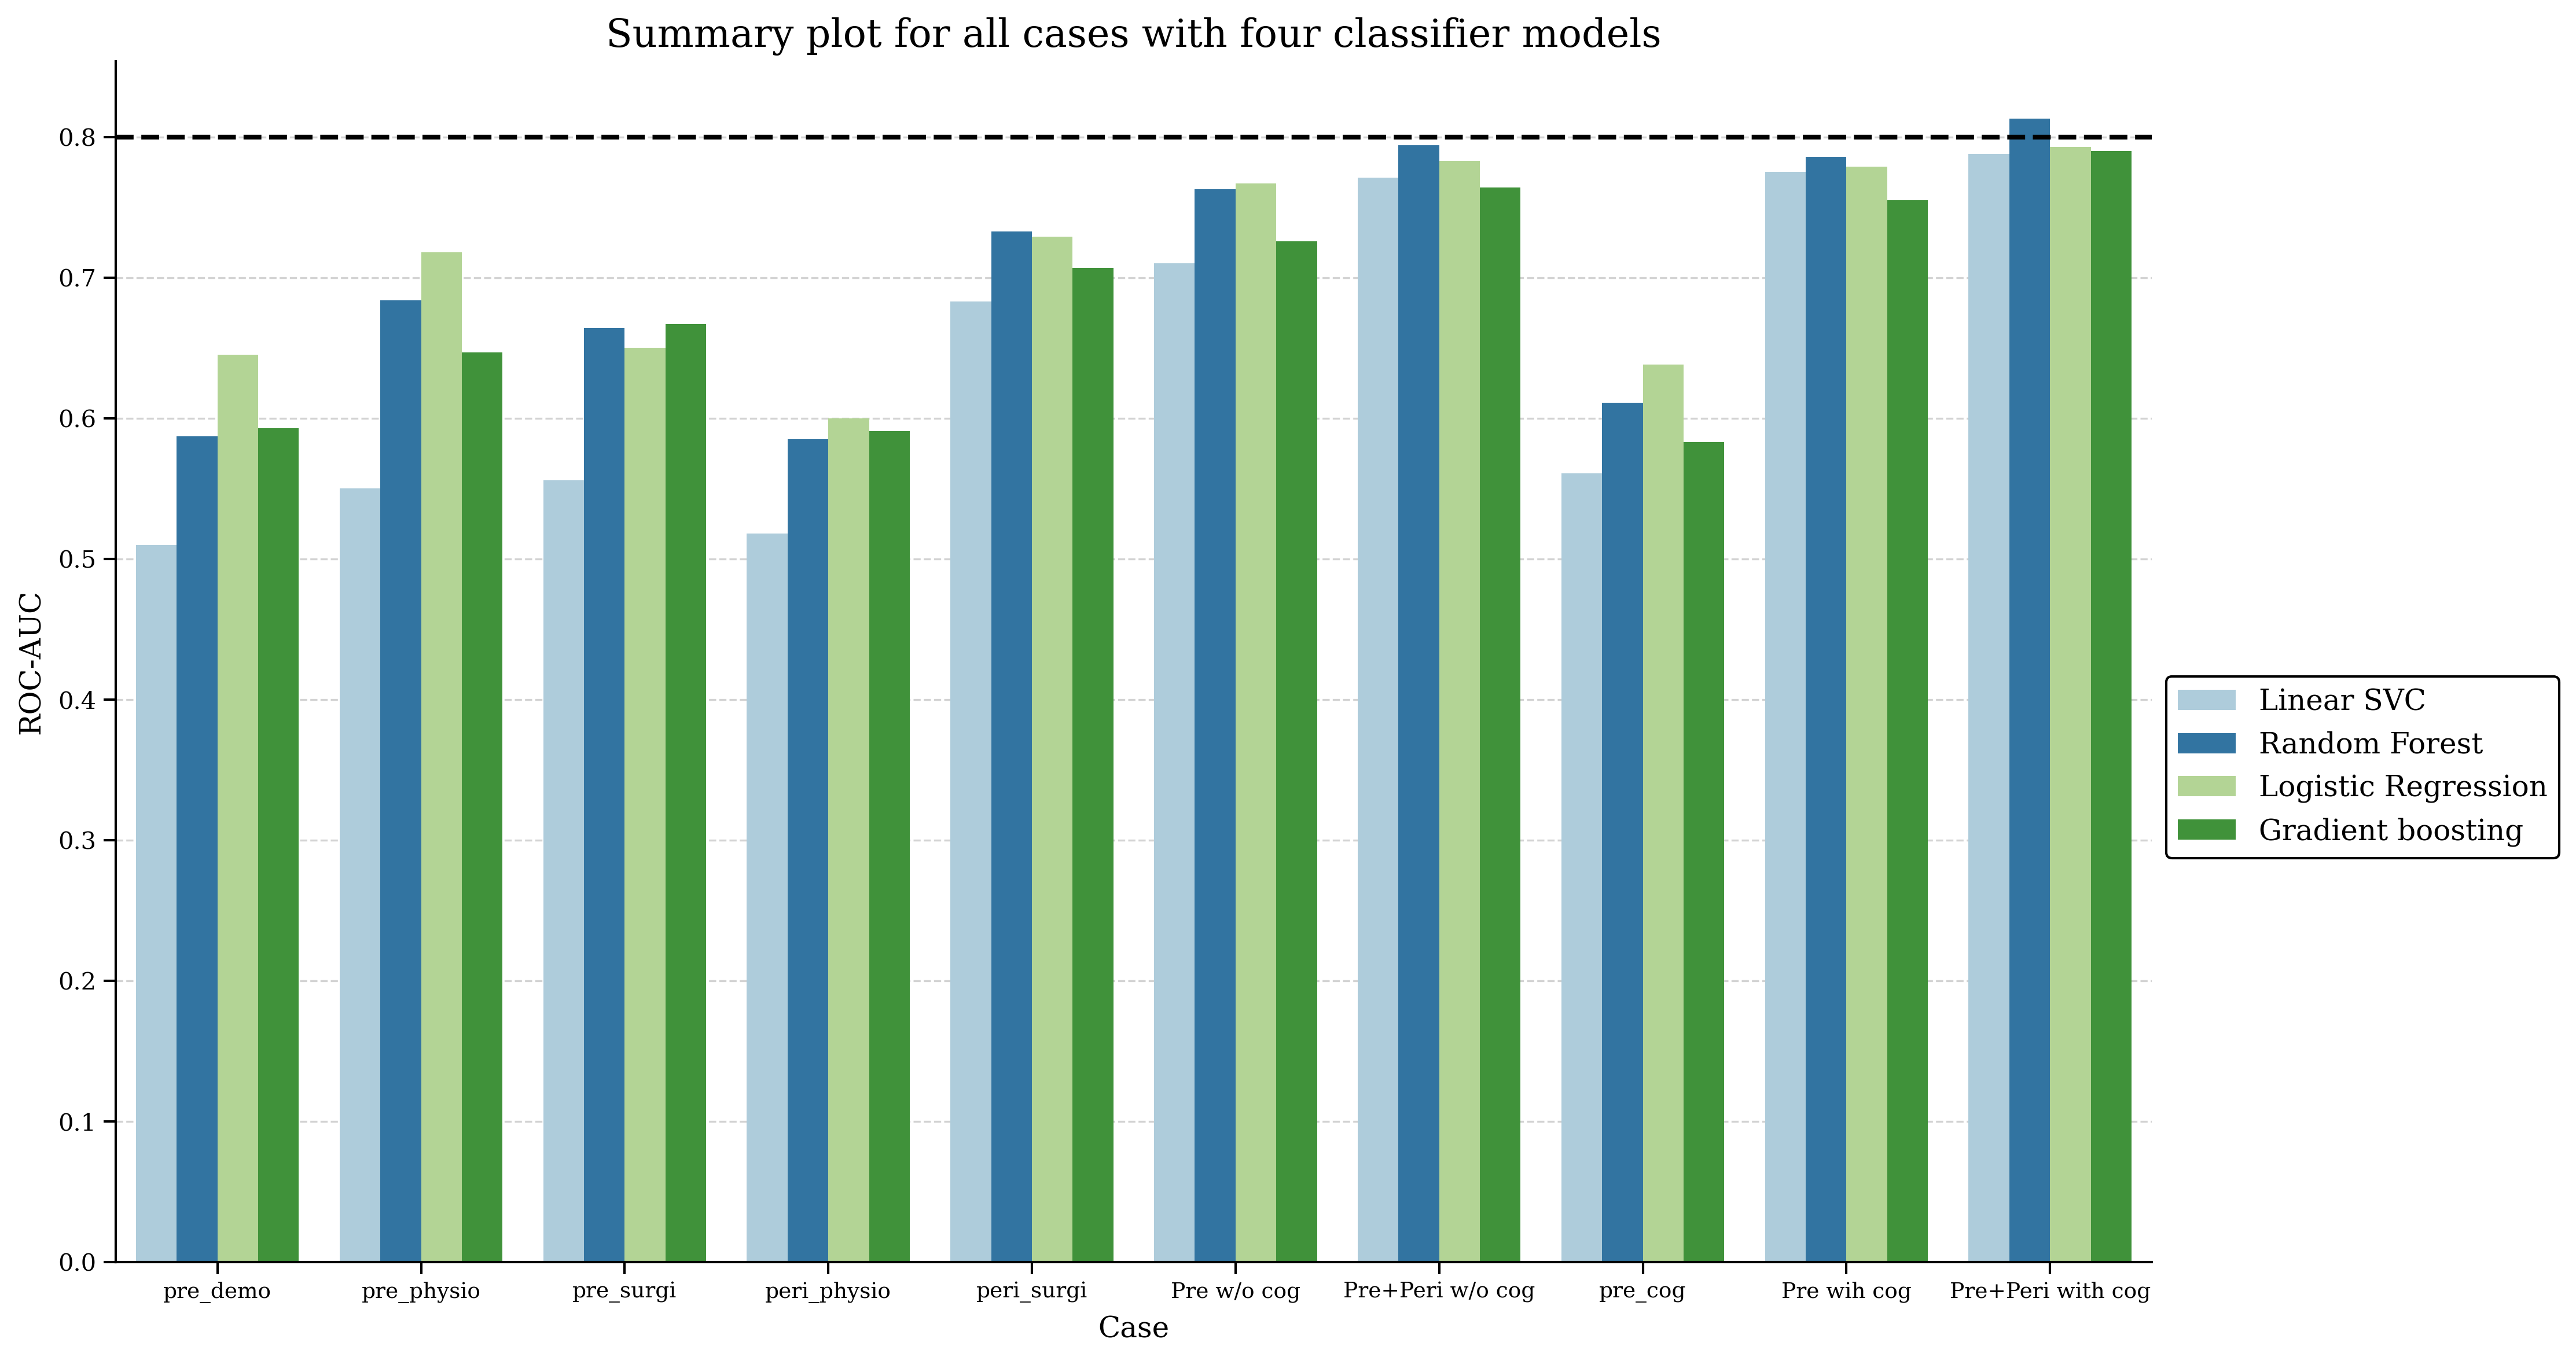

In [58]:


### Now plotting it
all_acc_frame = pd.read_csv(r'../intermediate_files/all_cases_4_model_acc_file.csv')


title = 'Summary plot for all cases with four classifier models'
fig, ax = plt.subplots(figsize=(15,8))

x_label, y_label = 'Case', 'ROC-AUC'
bar = sns.barplot(data=all_acc_frame, x=x_label, y=y_label, hue='Model', 
    palette=['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c'], ax=ax)

ax.set_title( title , fontsize=16)
ax.tick_params(axis='x', labelsize=9)

ax.set_xlabel(x_label, labelpad=5, fontdict={'size': 12}) #'weight': 'bold'
ax.set_ylabel(y_label, labelpad=5, fontdict={'size': 12}) # 'Metric Value (95% CI)'

ax.grid(axis='y', color='lightgray', linestyle='--')
ax.set_axisbelow(True)
ax.axhline(y=0.8, linestyle='--', linewidth=2, color='black',zorder=1)
ax.legend(bbox_to_anchor=[1,0.5])
# ax.legend([], [], frameon=False)

fig.tight_layout()

fig.savefig(os.path.join(image_folder,title+'.png'), dpi=300)

In [ ]:
# =============================================================================
# All 10 models with/without SMOTE and Random Forest
# =============================================================================

model_list= [RandomForestClassifier(n_jobs=-1)]
         
model_list1= ['Random Forest']


feat_list = [pre_demo, pre_physio, pre_surgi, peri_physio, peri_surgi, pre_demo+pre_physio+pre_surgi,
             pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi, pre_cog, pre_demo+pre_physio+pre_surgi+pre_cog,
             pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi+pre_cog]

feat_names_list = ['pre_demo', 'pre_physio', 'pre_surgi', 'peri_physio', 'peri_surgi', 'pre_demo+pre_physio+pre_surgi',
             'pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi', 'pre_cog', 'pre_demo+pre_physio+pre_surgi+pre_cog',
             'pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi+pre_cog']

names =  ['pre_demo', 'pre_physio', 'pre_surgi', 'peri_physio', 'peri_surgi', 'Pre w/o cog',
             'Pre+Peri w/o cog', 'pre_cog', 'Pre wih cog', 'Pre+Peri with cog']

img_str = '10 cases'

all_acc_frame= pd.DataFrame()

for i, feat_names in enumerate(feat_list):
    
    # Without Cognitive features
    feat_names1 = change_feat_to_hotenc(feat_names, encod_col, final_frame)
    
    X = final_frame.loc[:, feat_names1]
    Y = final_frame.loc[:,'T9_Delirum']
    
    feature_imp1, feature_all_frame1,ML_result_frame1,_,_ = ns_ML_model_test(model_list,model_list1,X,Y,5,apply_SMOTE=False,feat_len=None,return_proba=True, return_coef=False, n_repeats=1, Verbose=True)
    feature_imp2, feature_all_frame2,ML_result_frame2,_,_ = ns_ML_model_test(model_list,model_list1,X,Y,5,apply_SMOTE=1,feat_len=None,return_proba=True, return_coef=False, n_repeats=1, Verbose=True)
    
    temp_frame = pd.DataFrame({'Case': np.full((len(model_list)), names[i]), 'Model': ML_result_frame1.model, 'Oversampling': 'None',
                               'Balanced Accuracy': list(chain.from_iterable(ML_result_frame1.acc_bal.values))
                               , 'ROC-AUC': list(chain.from_iterable(ML_result_frame1.roc_auc.values))})
    
    temp_frame1 = pd.DataFrame({'Case': np.full((len(model_list)), names[i]), 'Model': ML_result_frame2.model,'Oversampling': 'SMOTE',
                               'Balanced Accuracy': list(chain.from_iterable(ML_result_frame2.acc_bal.values))
                               , 'ROC-AUC': list(chain.from_iterable(ML_result_frame2.roc_auc.values))})
    

    all_acc_frame = pd.concat([all_acc_frame, temp_frame, temp_frame1], join='outer', axis=0)


all_acc_frame = all_acc_frame.reset_index(drop=True)

# all_acc_frame.to_csv(os.path.join(save_files, 'all_cases_1_model_SMOTE_NONE_acc_file.csv'), index=False)



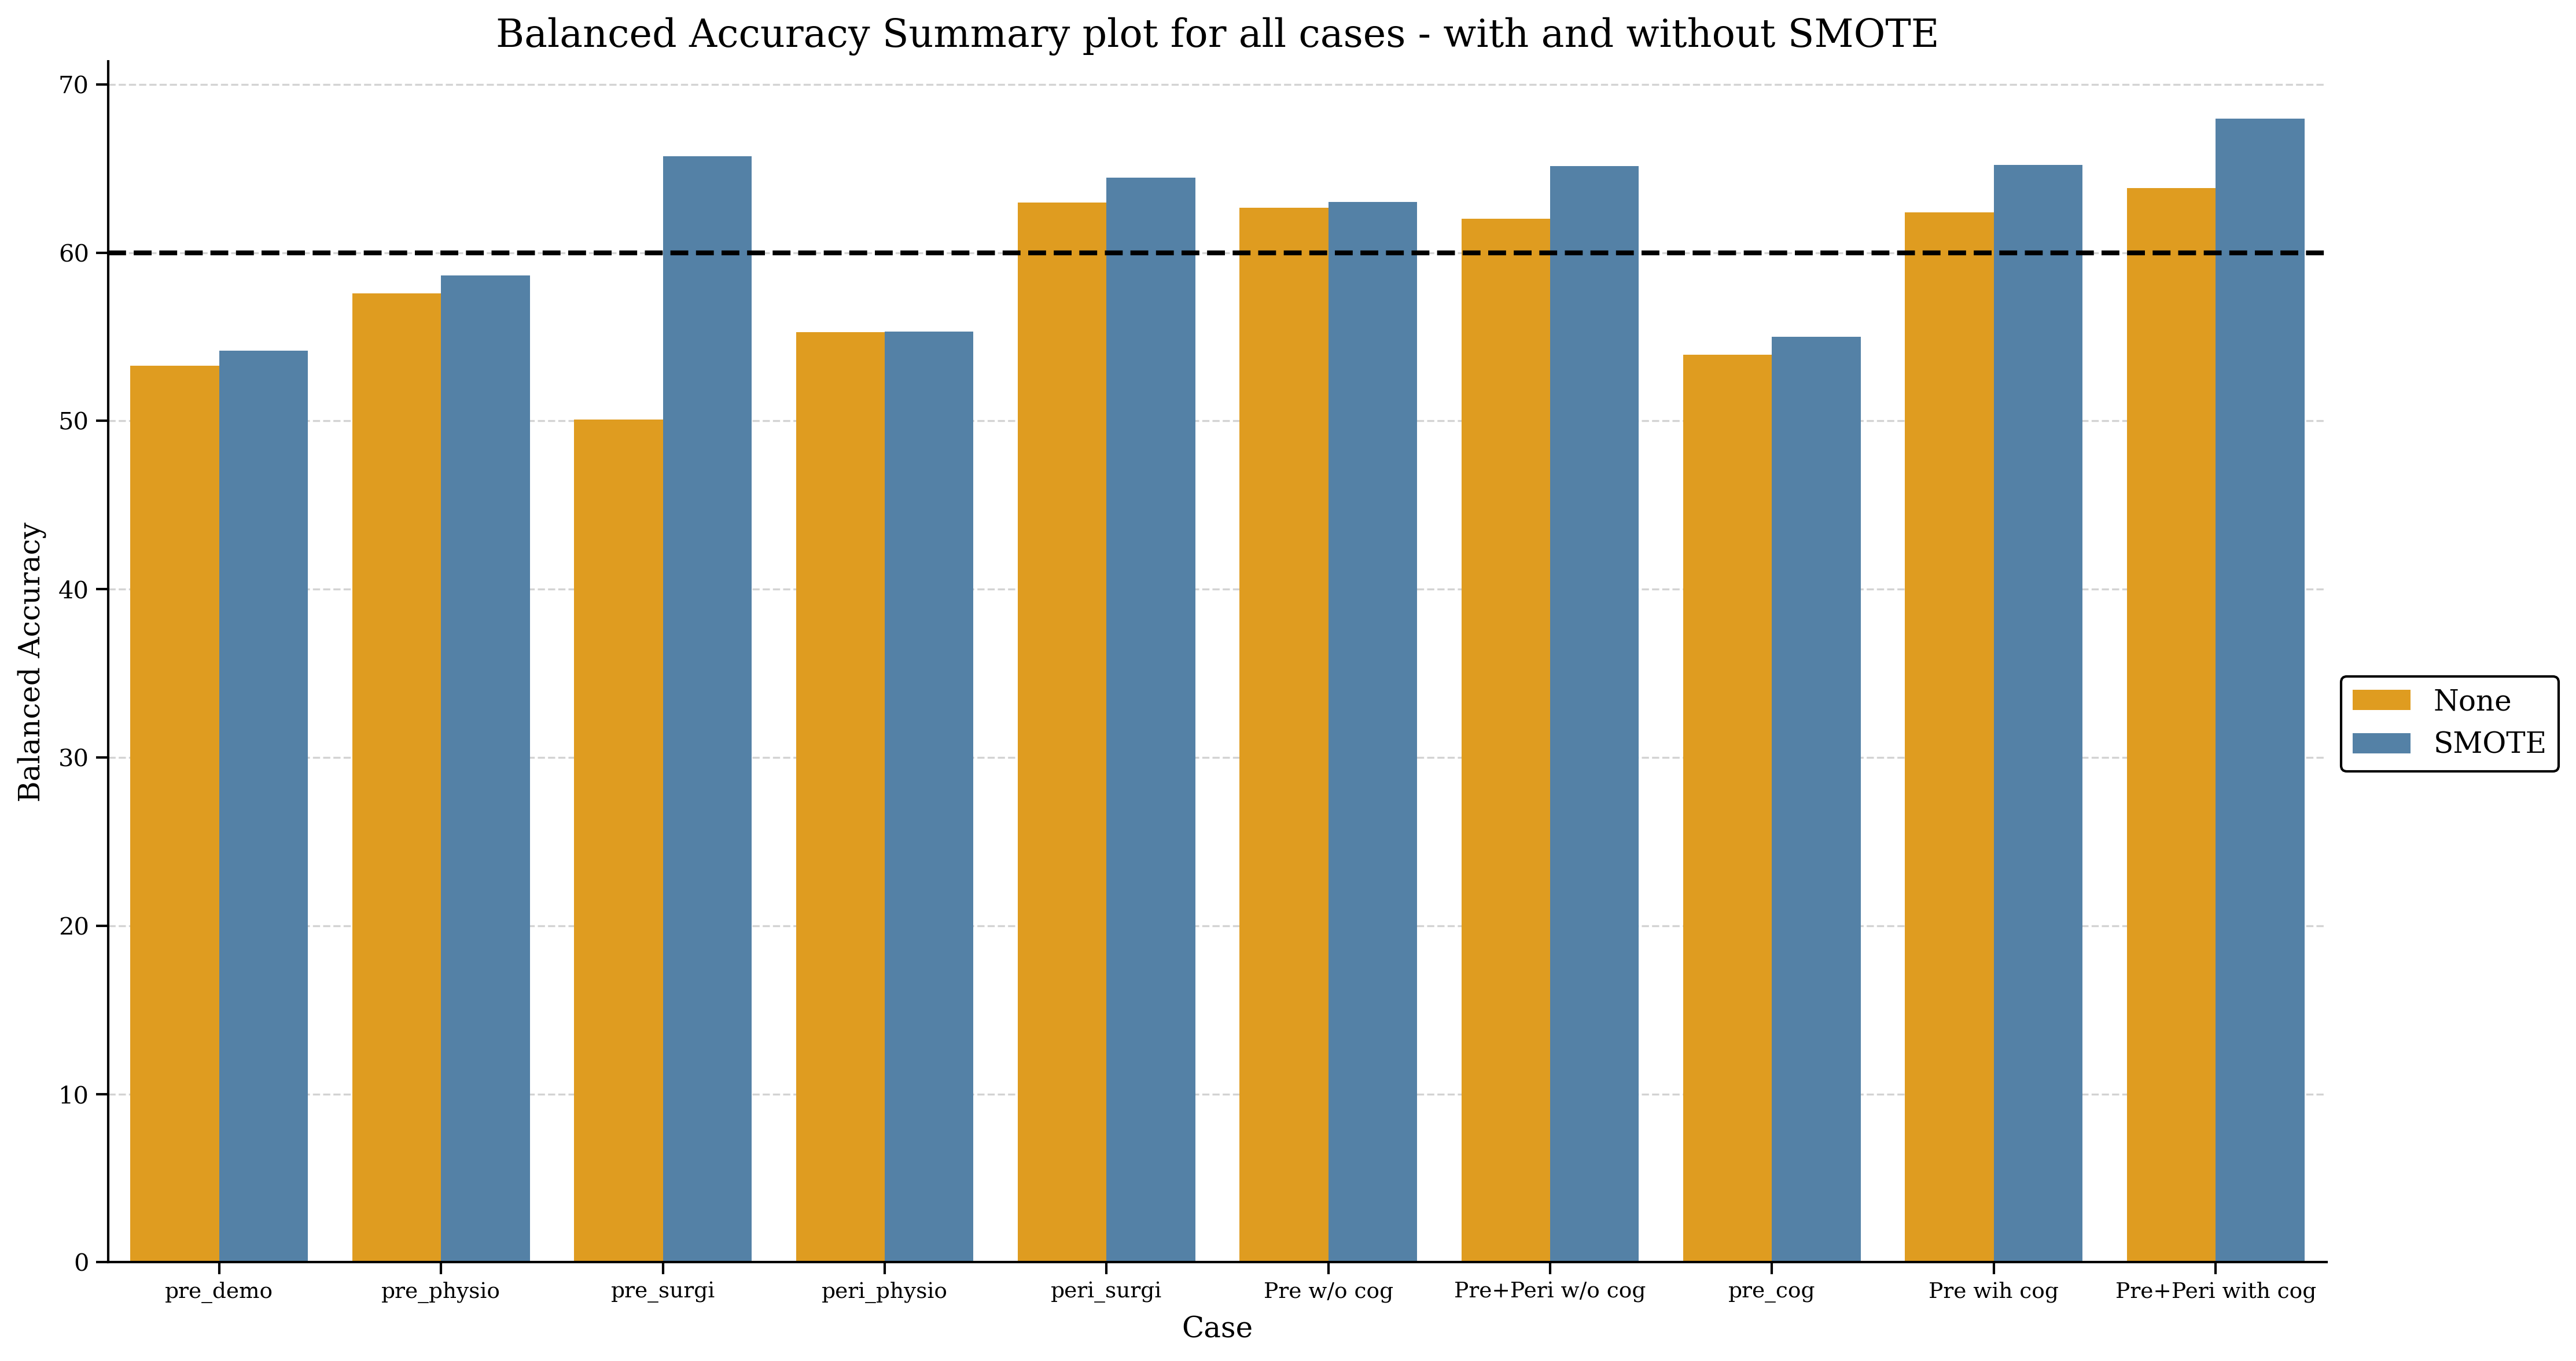

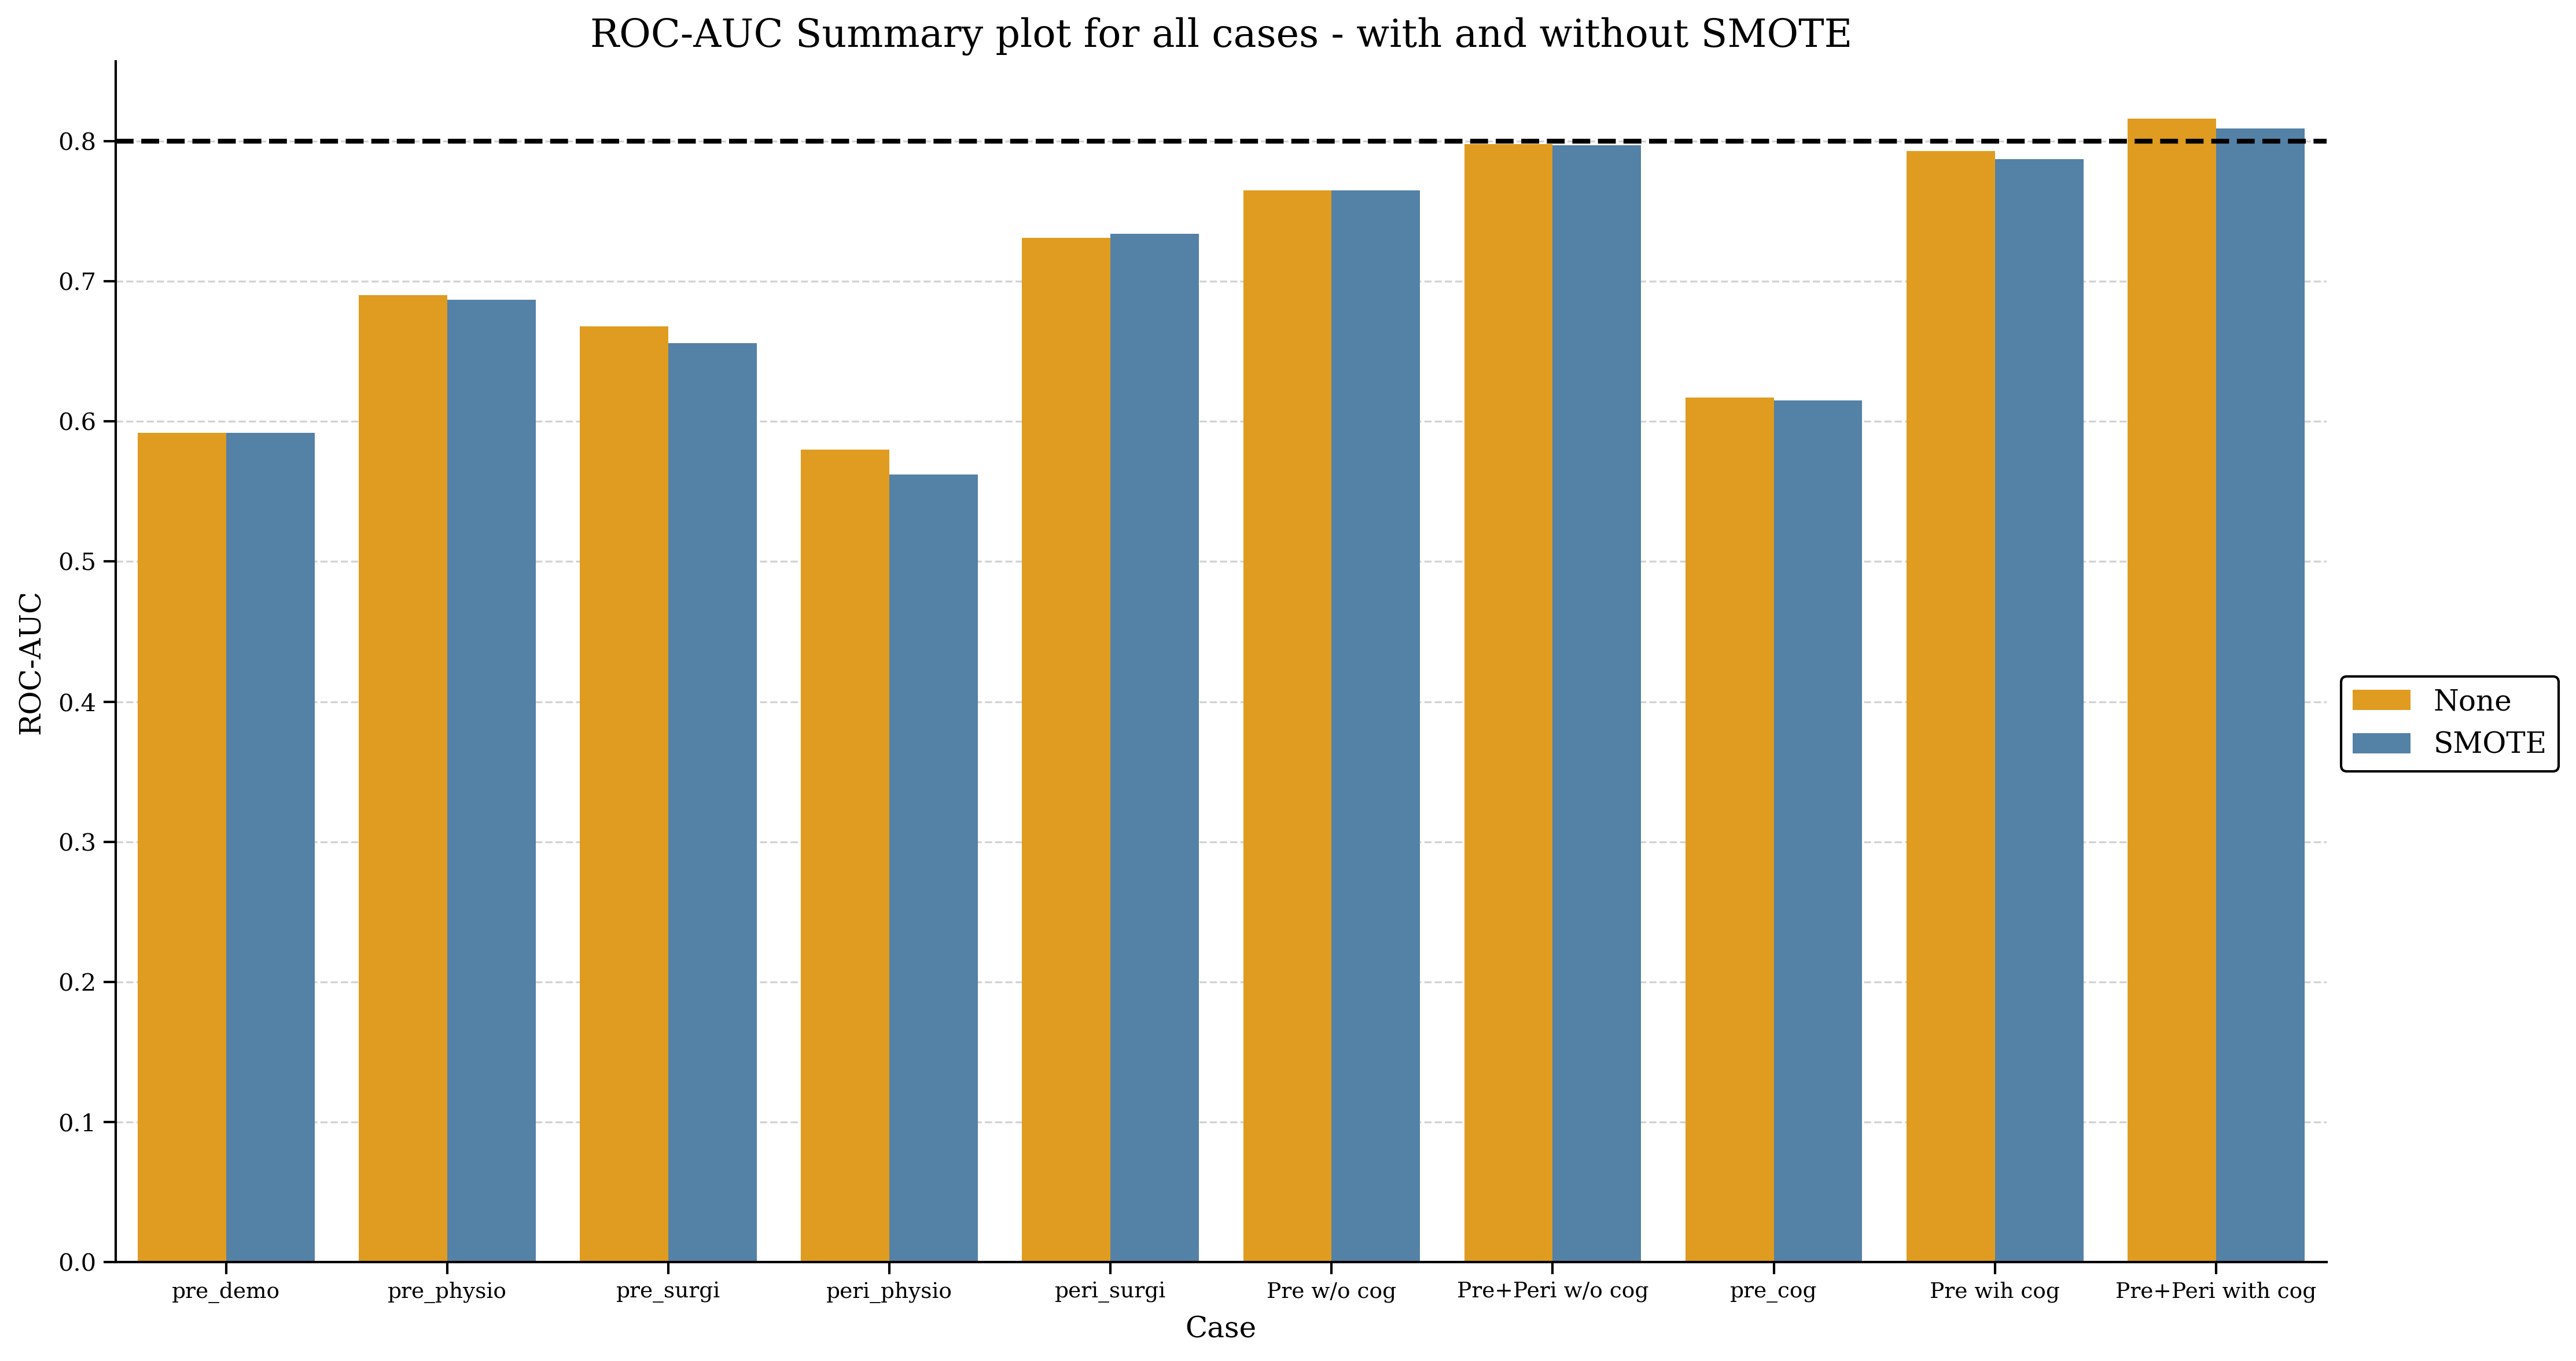

In [72]:
### Now plotting it


all_acc_frame = pd.read_csv(r'../intermediate_files/all_cases_1_model_SMOTE_NONE_acc_file.csv')
all_acc_frame['Oversampling'] = all_acc_frame['Oversampling'].fillna('None')


for (y_label, y_line ) in zip(['Balanced Accuracy', 'ROC-AUC'], [60, 0.8]):
    title = f'{y_label} Summary plot for all cases - with and without SMOTE'
    fig, ax = plt.subplots(figsize=(15,8))

    x_label = 'Case'
    bar = sns.barplot(data=all_acc_frame, x=x_label, y=y_label, hue='Oversampling', 
        palette=['Orange', 'Steelblue'], ax=ax)

    ax.set_title( title , fontsize=16)
    ax.tick_params(axis='x', labelsize=9)

    ax.set_xlabel(x_label, labelpad=5, fontdict={'size': 12}) #'weight': 'bold'
    ax.set_ylabel(y_label, labelpad=5, fontdict={'size': 12}) # 'Metric Value (95% CI)'

    ax.grid(axis='y', color='lightgray', linestyle='--')
    ax.set_axisbelow(True)
    ax.axhline(y=y_line, linestyle='--', linewidth=2, color='black',zorder=1)
    ax.legend(bbox_to_anchor=[1,0.5])
    # ax.legend([], [], frameon=False)

    fig.tight_layout()

    fig.savefig(os.path.join(image_folder,title+'.png'), dpi=300)

In [ ]:
# =============================================================================
# Supplementary figure - 10 models with and without removal of outliers
# =============================================================================
# First run the code till X= final_frame in the original code of "del_withoutSMOT_finalv2" abd save it in variable
# called final_frame1 = final_frame.copy()
## Now a sanity check if they are different or not
a = final_frame.compare(final_frame1)
b = a.sum(axis=0)



model_list= [RandomForestClassifier(n_jobs=-1)]
         
model_list1= ['Random Forest']


feat_list = [pre_demo, pre_physio, pre_surgi, peri_physio, peri_surgi, pre_demo+pre_physio+pre_surgi,
             pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi, pre_cog, pre_demo+pre_physio+pre_surgi+pre_cog,
             pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi+pre_cog]

feat_names_list = ['pre_demo', 'pre_physio', 'pre_surgi', 'peri_physio', 'peri_surgi', 'pre_demo+pre_physio+pre_surgi',
             'pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi', 'pre_cog', 'pre_demo+pre_physio+pre_surgi+pre_cog',
             'pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi+pre_cog']

names =  ['pre_demo', 'pre_physio', 'pre_surgi', 'peri_physio', 'peri_surgi', 'Pre w/o cog',
             'Pre+Peri w/o cog', 'pre_cog', 'Pre wih cog', 'Pre+Peri with cog']

img_str = '10 cases'

all_acc_frame= pd.DataFrame()

for i, feat_names in enumerate(feat_list):
    
    # Without Cognitive features
    feat_names1 = change_feat_to_hotenc(feat_names, encod_col)
    
    X = final_frame.loc[:, feat_names1]
    Y = final_frame.loc[:,'T9_Delirum']
    
    feature_imp1, feature_all_frame1,ML_result_frame1,_,_ = ns_ML_model_test(model_list,model_list1,X,Y,5,apply_SMOTE=False,feat_len=None,return_proba=True, return_coef=False, n_repeats=1, Verbose=True)

    # Here is the one where outliers were removed
    X = final_frame1.loc[:, feat_names1]
    Y = final_frame1.loc[:,'T9_Delirum']

    feature_imp2, feature_all_frame2,ML_result_frame2,_,_ = ns_ML_model_test(model_list,model_list1,X,Y,5,apply_SMOTE=False,feat_len=None,return_proba=True, return_coef=False, n_repeats=1, Verbose=True)
    
    temp_frame = pd.DataFrame({'Case': np.full((len(model_list)), names[i]), 'Model': ML_result_frame1.model, 'Outlier Removed': 'No',
                               'Balanced Accuracy': list(chain.from_iterable(ML_result_frame1.acc_bal.values))
                               , 'ROC-AUC': list(chain.from_iterable(ML_result_frame1.roc_auc.values))})
    
    temp_frame1 = pd.DataFrame({'Case': np.full((len(model_list)), names[i]), 'Model': ML_result_frame2.model,'Outlier Removed': 'Yes',
                               'Balanced Accuracy': list(chain.from_iterable(ML_result_frame2.acc_bal.values))
                               , 'ROC-AUC': list(chain.from_iterable(ML_result_frame2.roc_auc.values))})
    

    all_acc_frame = pd.concat([all_acc_frame, temp_frame, temp_frame1], join='outer', axis=0)


all_acc_frame = all_acc_frame.reset_index(drop=True)

# all_acc_frame.to_csv(os.path.join(save_files, 'all_cases_1_model_SMOTE_NONE_acc_file_outlier_removed.csv'), index=False)



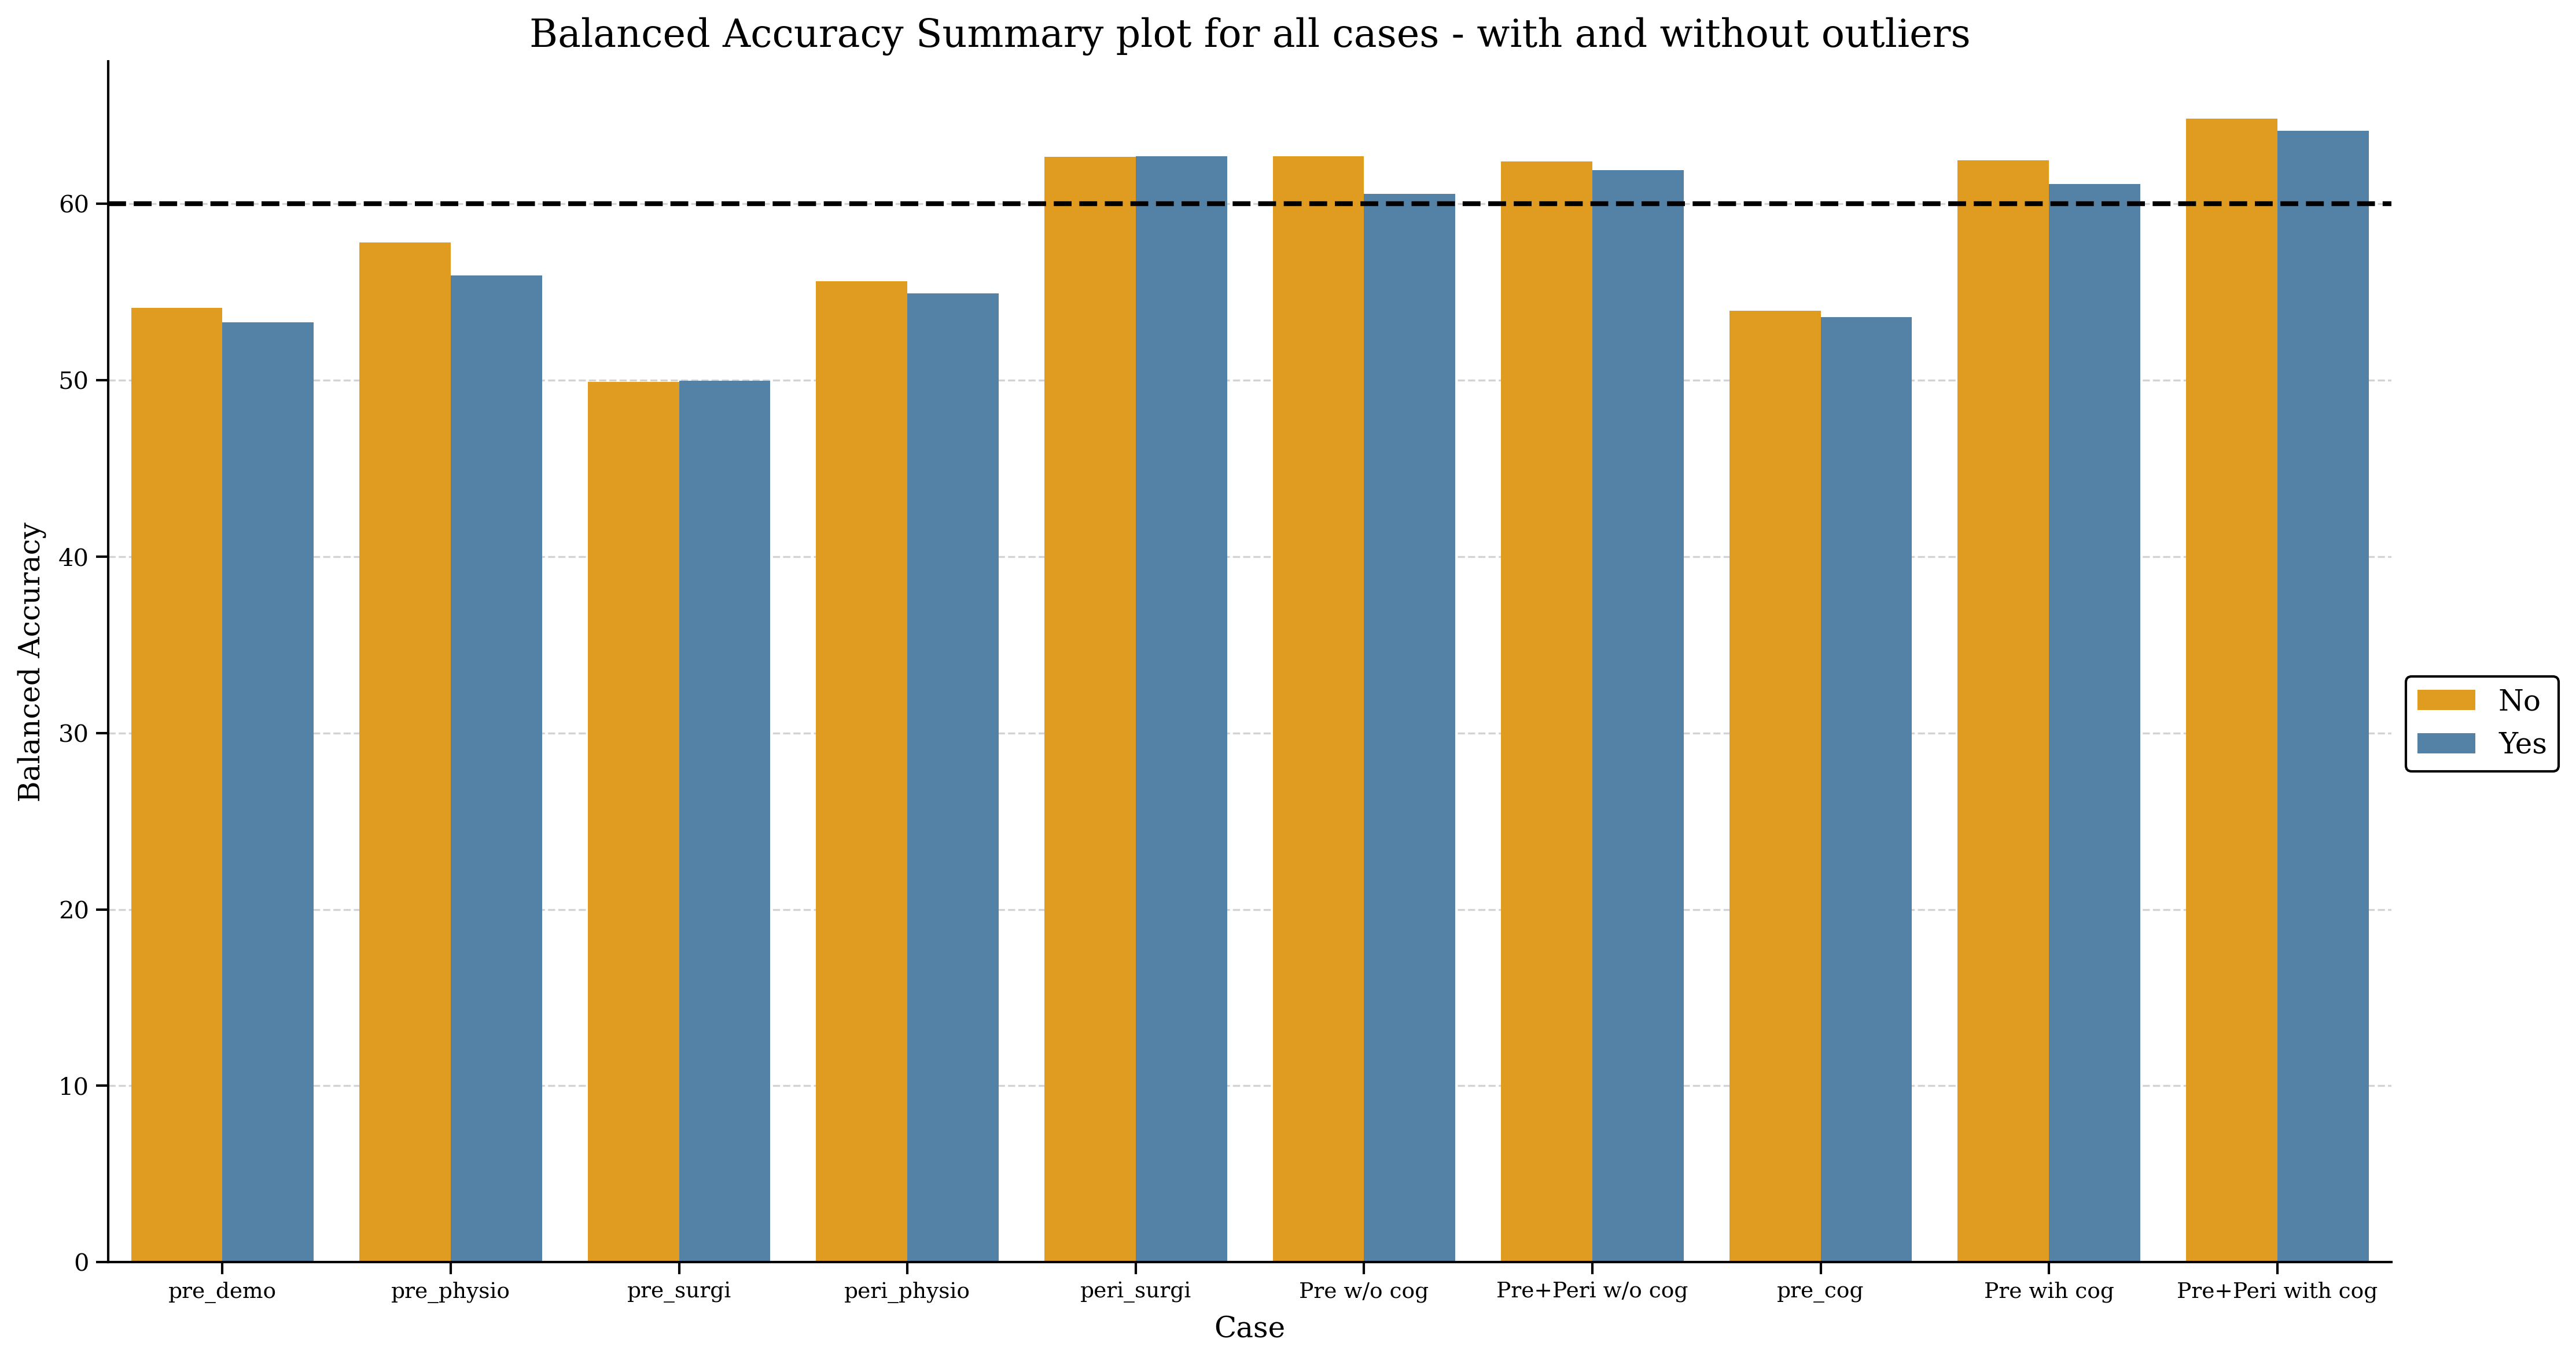

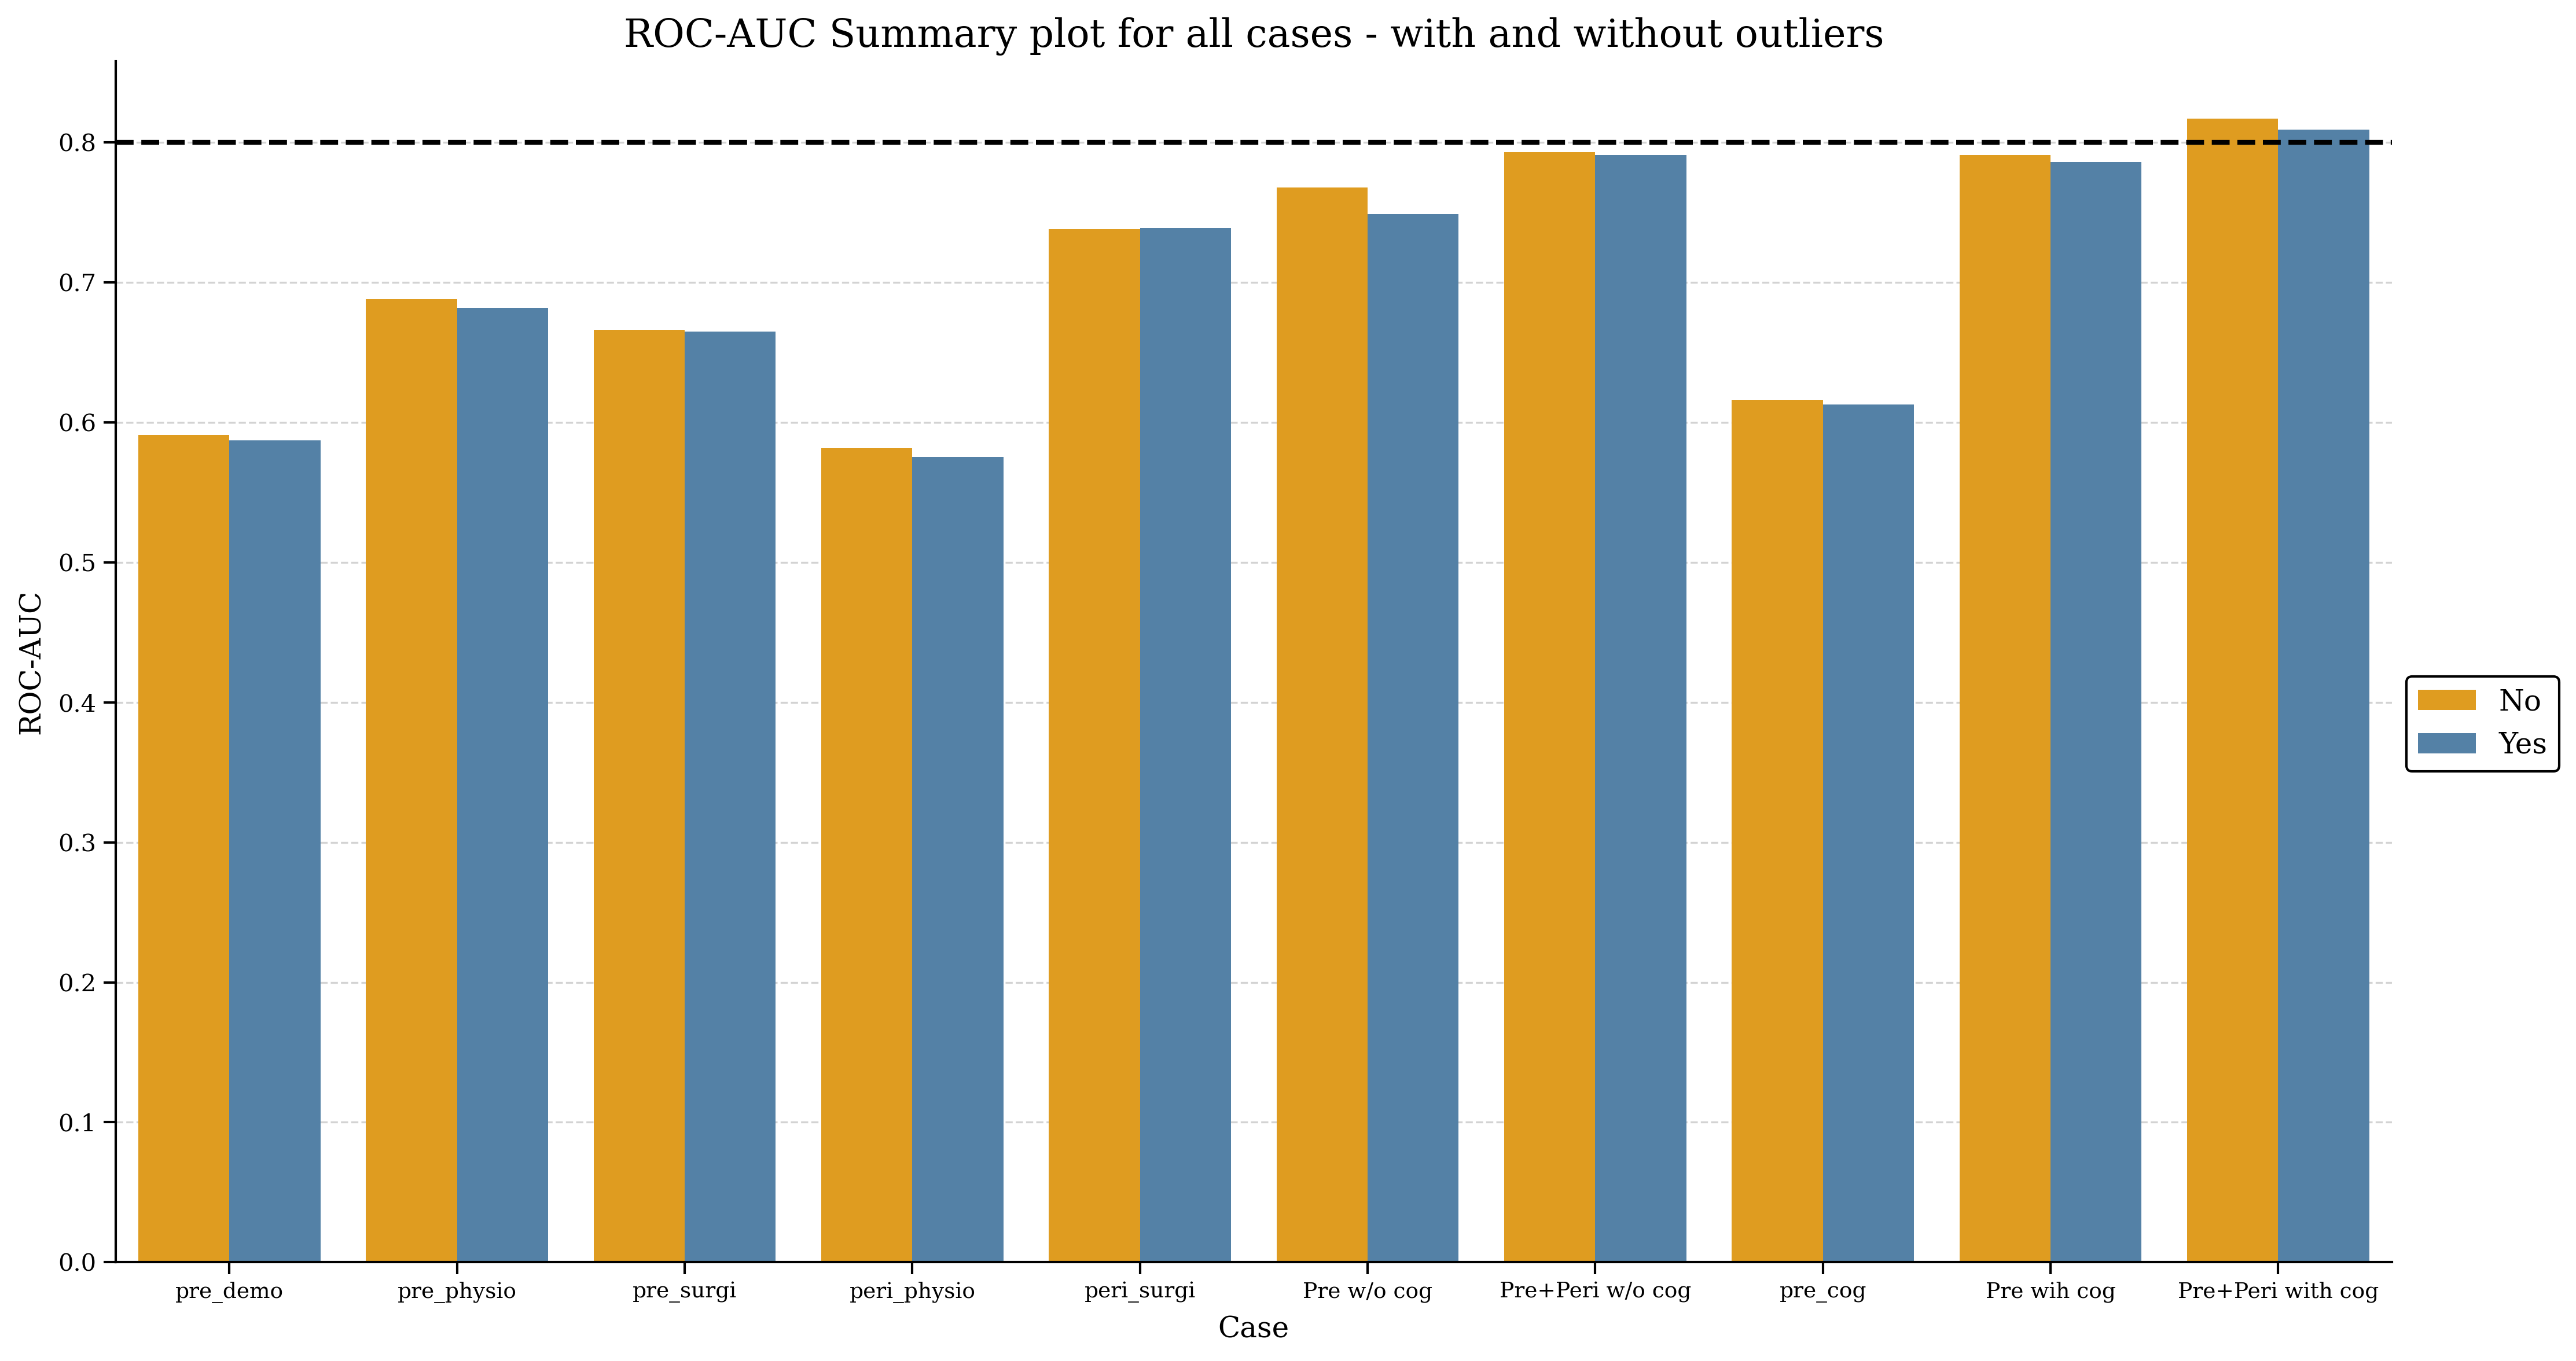

In [73]:
### Now plotting it

all_acc_frame = pd.read_csv(r'../intermediate_files/all_cases_1_model_SMOTE_NONE_acc_file_outlier_removed.csv')

for (y_label, y_line ) in zip(['Balanced Accuracy', 'ROC-AUC'], [60, 0.8]):

    title = f'{y_label} Summary plot for all cases - with and without outliers'
    fig, ax = plt.subplots(figsize=(15,8))

    x_label = 'Case'
    sns.barplot(data=all_acc_frame, x=x_label, y=y_label, hue='Outlier Removed', 
        palette=['Orange', 'Steelblue'], ax=ax)

    ax.set_title( title , fontsize=16)
    ax.tick_params(axis='x', labelsize=9)

    ax.set_xlabel(x_label, labelpad=5, fontdict={'size': 12}) #'weight': 'bold'
    ax.set_ylabel(y_label, labelpad=5, fontdict={'size': 12}) # 'Metric Value (95% CI)'

    ax.grid(axis='y', color='lightgray', linestyle='--')
    ax.set_axisbelow(True)
    ax.axhline(y=y_line, linestyle='--', linewidth=2, color='black',zorder=1)
    ax.legend(bbox_to_anchor=[1,0.5])
    # ax.legend([], [], frameon=False)

    fig.tight_layout()

    fig.savefig(os.path.join(image_folder,title+'.png'), dpi=300)


### Additional Visualizations

100%|██████████| 4/4 [00:10<00:00,  2.64s/it]



Features in pre_demo are 11


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]



Features in pre_physio are 24


100%|██████████| 4/4 [00:05<00:00,  1.50s/it]



Features in pre_surgi are 15


100%|██████████| 4/4 [00:07<00:00,  1.89s/it]



Features in peri_physio are 4


100%|██████████| 4/4 [00:06<00:00,  1.71s/it]



Features in peri_surgi are 15


100%|██████████| 4/4 [00:08<00:00,  2.05s/it]



Features in pre_demo+pre_physio+pre_surgi are 50


100%|██████████| 4/4 [00:11<00:00,  2.95s/it]



Features in pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi are 69


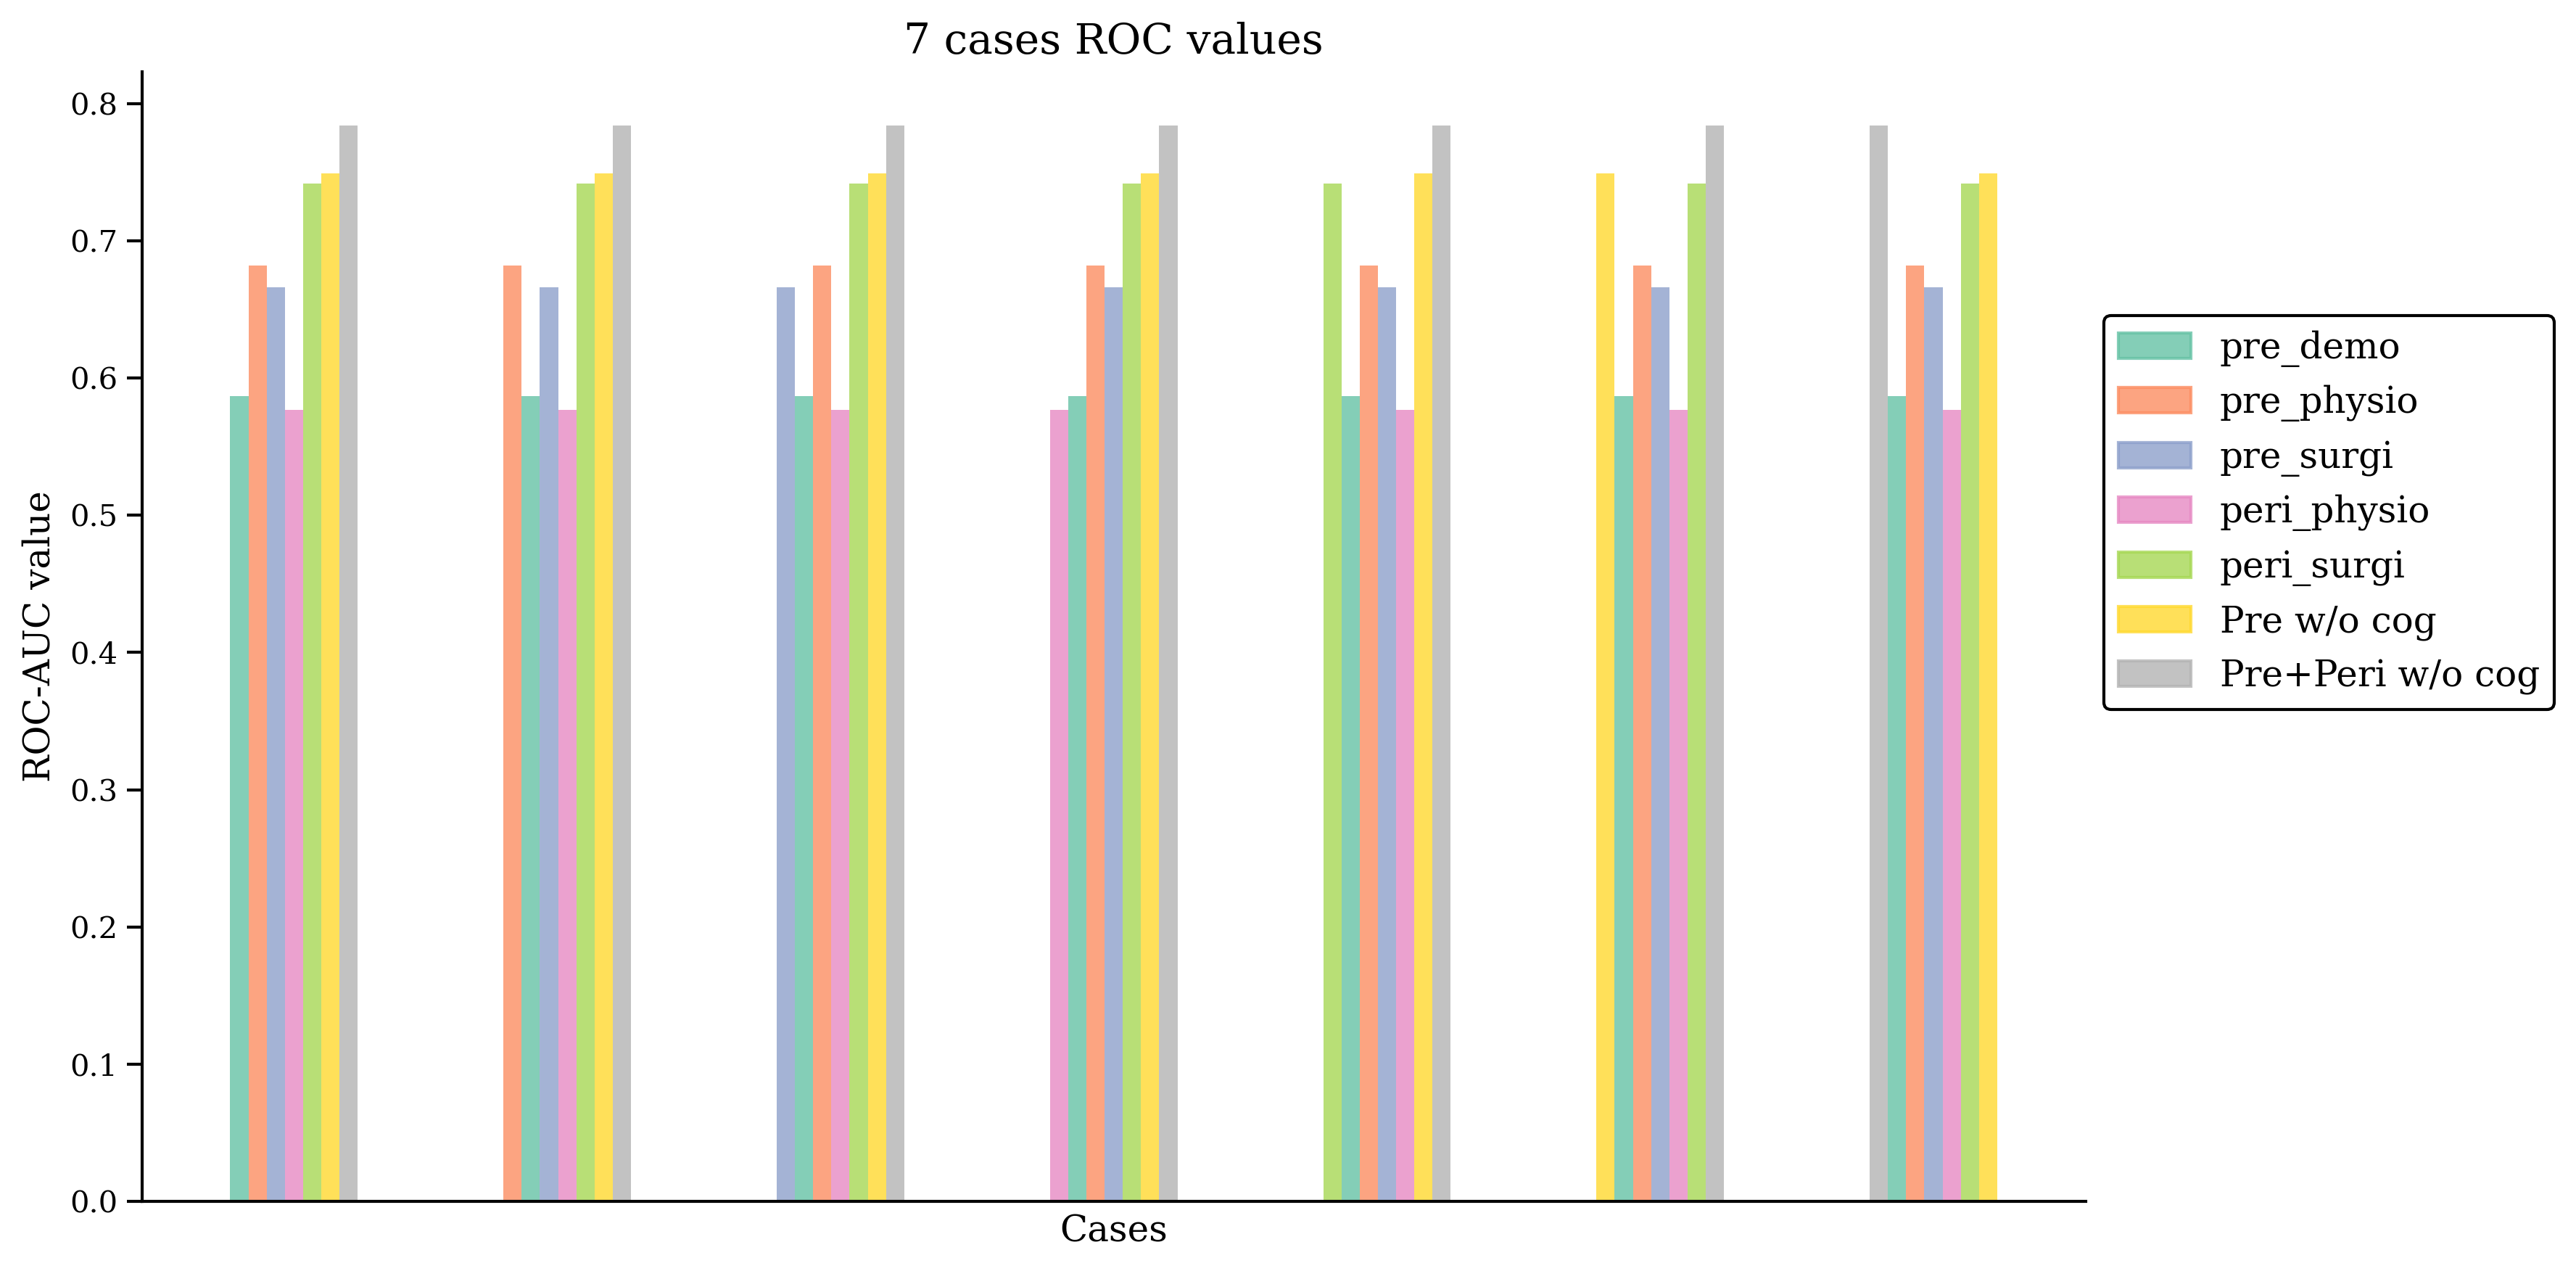

In [63]:
# =============================================================================
# Fig 1 d and e of supplement
# =============================================================================
feat_list = [pre_demo, pre_physio, pre_surgi, peri_physio, peri_surgi, pre_demo+pre_physio+pre_surgi,
             pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi]

feat_names_list = ['pre_demo', 'pre_physio', 'pre_surgi', 'peri_physio', 'peri_surgi', 'pre_demo+pre_physio+pre_surgi',
             'pre_demo+pre_physio+pre_surgi + peri_physio+peri_surgi']

names =  ['pre_demo', 'pre_physio', 'pre_surgi', 'peri_physio', 'peri_surgi', 'Pre w/o cog',
             'Pre+Peri w/o cog']
img_str = '7 cases'

# Hot encoded features:
encod_col = ['location','T1_SMI', 'T2_narc_kind', 'T2_OP_kind_general']


df_each_case = pd.DataFrame()

for i, feat_names in enumerate(feat_list):
    
    # Without Cognitive features
    feat_names1 = change_feat_to_hotenc(feat_names, encod_col, final_frame)
    
    X = final_frame.loc[:, feat_names1]
    Y = final_frame.loc[:,'T9_Delirum']
    
    feature_imp1, feature_all_frame1,ML_result_frame1,_,_ = ns_ML_model_test(model_list,model_list1,X,Y,5,apply_SMOTE=False,feat_len=None,return_proba=True, return_coef=False, n_repeats=1)
    
    ############################################
    # Saving the values from a particular classifier from each case to plot them together as a bar plot
    model_name = 'Random Forest'    
    one_row = ML_result_frame1[ML_result_frame1.loc[:,'model']==model_name]
    
    df_each_case = pd.concat([df_each_case, one_row], ignore_index=True)
    

    ################################################## ROC Curve
    # plot_roc_curves_one_model(ML_result_frame1, img_str=feat_names_list[i] ,model_name='Random Forest',legend_list=['Features','Without Cognitive', 'With Cognitive'])
    
    
    print('\nFeatures in {} are {}'.format(feat_names_list[i],ML_result_frame1.feat_sel_len[0]))
    
# Now plotting the saved file of a particular classfier from each case
df_each_case1  =  df_each_case.copy()
df_each_case1.model = feat_names_list

######################### Arranging data in desired format
# Color map for models
n=len(names)
cmap = plt.get_cmap("Set2")
colors = cmap.colors
indices = np.linspace(0, len(colors) - 1, n, dtype=int) # Use numpy.linspace to create 7 equally spaced color indices
color_map = [colors[i] for i in indices]



ind_list = list(np.arange(0,len(df_each_case1)))
modi_frame = pd.DataFrame()
color_list=[]
for i,case in enumerate(feat_names_list):
    temp_frame1 = pd.DataFrame({'case':[i], 'hue': 'hue 1', 'roc_auc':df_each_case1.loc[i, 'roc_auc'], 'acc_bal':df_each_case1.loc[i, 'acc_bal']})
    
    modi_frame =  pd.concat([modi_frame, temp_frame1], ignore_index=True)
    # Nowing the remaning
    ind_list1 = ind_list.copy()
    ind_list1.remove(i)
    k=1
    for j in ind_list1:
        k=k+1
        temp_frame2 = pd.DataFrame({'case':[i], 'hue': f'hue {k}', 'roc_auc':df_each_case1.loc[j, 'roc_auc'], 'acc_bal':df_each_case1.loc[j, 'acc_bal']})
        modi_frame =  pd.concat([modi_frame, temp_frame2], ignore_index=True)
        
    order = [i] + ind_list1
    if i==0:
        color_list = list(np.array(color_map)[order])
    else: 
        temp_color = list(np.array(color_map)[order])
        color_list = color_list+temp_color

multi_bar_plot(color_list, image_folder,  names, modi_frame, color_map, img_str, alpha_val=0.8)
